# Transformers

Basic Attention Mechanisms

- Soft Attention – Computes weighted sums of all input elements.
- Hard Attention – Selects specific input elements (non-differentiable).
- Additive Attention (Bahdanau Attention) – Uses learned weights to compute attention scores.
- Multiplicative Attention (Luong Attention) – Uses dot-product similarity between Query and Key.
- Attention-based RNNs for NLP (Seq2Seq, Transformers)

## What is Attention?

Attention is a mechanism that helps models focus on important parts of input data while ignoring irrelevant details.
* It’s widely used in
  * NLP (GPT, BERT, T5), Vision (ViTs, Swin Transformer), and
  * generative models (Stable Diffusion, DALLE-2).

### Why Do We Need Attention?

Traditional models like RNNs & LSTMs struggle with:
- Long Sequences – Hard to capture dependencies over long distances.
- Fixed-Length Memory – Cannot retain all past information.
- Computational Bottleneck – Sequential processing slows down training.

💡 Solution? Attention allows the model to "look" at all inputs at once and decide what’s important.

Instead of treating all input words (or image patches) equally, attention assigns higher weights to the most relevant parts.

###Self-Attention (Scaled Dot-Product Attention)

**How Attention Mechanism Works?**

The most common form in Transformers is `scaled dot-product attention`.

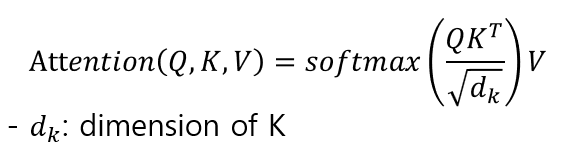

Where:
- Query (Q) – What we’re looking for in the input.
- Key (K) – Represents all possible words to attend to.
- Value (V) – The actual information we retrieve.
- Softmax – Converts scores into probabilities.
- Scaling Factor (dk) – Prevents large values from dominating softmax.

**1. Inputs: Tokens as Vectors**

- Start with a sequence of tokens (e.g., words in a sentence).
- Each token is represented as a vector (an embedding), say of size d model (e.g., 512 dimensions).
- For a sequence of n tokens, you have a matrix X∈R_n×d model.

**2. Create Queries, Keys, and Values**

- From each token’s vector, compute three new vectors:
  - Query (Q): What am I looking for?
  - Key (K): What do others offer?
  - Value (V): What information do they provide?

- These are generated by multiplying X with learned weight matrices:
  - Q = X.W_Q
  - K = X.W_K
  - V = X.W_V

- Each of W_Q, W_K, and W_V is a matrix of size d_model×d_k (where d_k is typically d_model/h, and h is the number of attention heads—more on that later).

Result: Q, K, and V are all n×d_k.

### Math Behind Attention

**3. Compute Attention Scores**

- Measure how much each token’s query matches every other token’s key using a dot product:
  - Q.K^T gives a matrix of size n×n, where each entry (i,j) is the raw "similarity" between token i’s query and token j’s key.

- Scale this by d_k to prevent large values (which can destabilize training):
  - (Q.K^T)/√d_k

**4. Softmax: Turn Scores into Weights**

- Apply the softmax function row-wise to normalize these scores into probabilities:

  - Attention Weights = softmax( (Q.K^T)/√d_k ).
- Each row sums to 1, representing how much focus token i gives to every token j.

**5. Weighted Sum of Values**

- Use these weights to combine the values (V):

  - Attention(Q,K,V) = softmax( (Q.K^T)/√d_k ).V
  - Output = Attention(Q,K,V) = Attention Weights×V
- Output is a new n×d_v matrix (where d_v is typically d_k), with each token’s representation now a weighted blend of all tokens’ values, guided by the attention weights.

Let's walk through a small numerical example.

In [ ]:
import torch
import torch.nn.functional as F

# Input embeddings (2 tokens, 2 dimensions)
X = torch.tensor([[1.0, 0.0], [0.0, 1.0]])

# Weight matrices (identity for simplicity)
W_Q = W_K = W_V = torch.eye(2)

# Compute Q, K, V
Q = X @ W_Q  # [2, 2]
K = X @ W_K  # [2, 2]
V = X @ W_V  # [2, 2]

# Attention scores
d_k = 2
scores = (Q @ K.T) / (d_k ** 0.5)  # [2, 2]

# Softmax
weights = F.softmax(scores, dim=-1)  # [2, 2]

# Weighted sum
output = weights @ V  # [2, 2]

print("Attention Weights:\n", weights) # heatmap
print("Output:\n", output)

Attention Weights:
 tensor([[0.6698, 0.3302],
        [0.3302, 0.6698]])
Output:
 tensor([[0.6698, 0.3302],
        [0.3302, 0.6698]])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k):
        super().__init__()
        self.d_k = d_k  # Key dimension

    def forward(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = F.softmax(scores, dim=-1)  # Apply softmax
        output = torch.matmul(attn_weights, V)  # Weighted sum of values

        return output, attn_weights


###Why Scale by √d_k?

- The dot product Q.K^T can grow large as d_k (the dimension of keys/queries) increases, especially in high-dimensional spaces.
- Large values push the softmax into regions with tiny gradients, slowing learning.
- Dividing by √d_k keeps the scores in a reasonable range, stabilizing training.

### Multi-Head Self-Attention (MHSA)

**Problem with Single Attention Head:**

- A single attention head can only capture one type of relationship (e.g., word similarity).
- But language and images have multiple types of relationships (e.g., grammar, meaning, structure).

💡 Solution? Multi-Head Attention (MHSA) – Instead of a single attention mechanism, we use multiple parallel attention heads.

**How Does MHSA Work?**

- Split Q, K, and V into h smaller chunks (e.g., if d_model = 512 and h = 8, each head gets d_k = d_v = 64).
- Compute attention independently for each head.
- Concatenate the results and pass them through a linear layer.

Why? Each head can focus on different patterns (e.g., syntax vs. semantics).

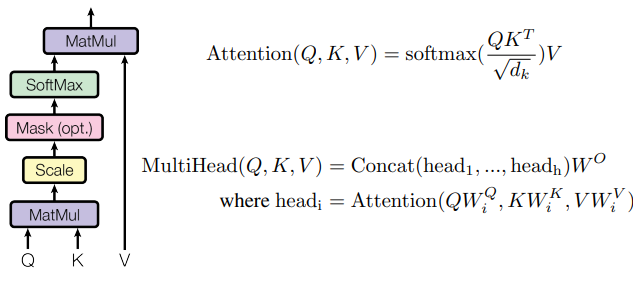

where
head_i = Attention(Q_i, K_i, V_i), and W_O is a learned output projection.

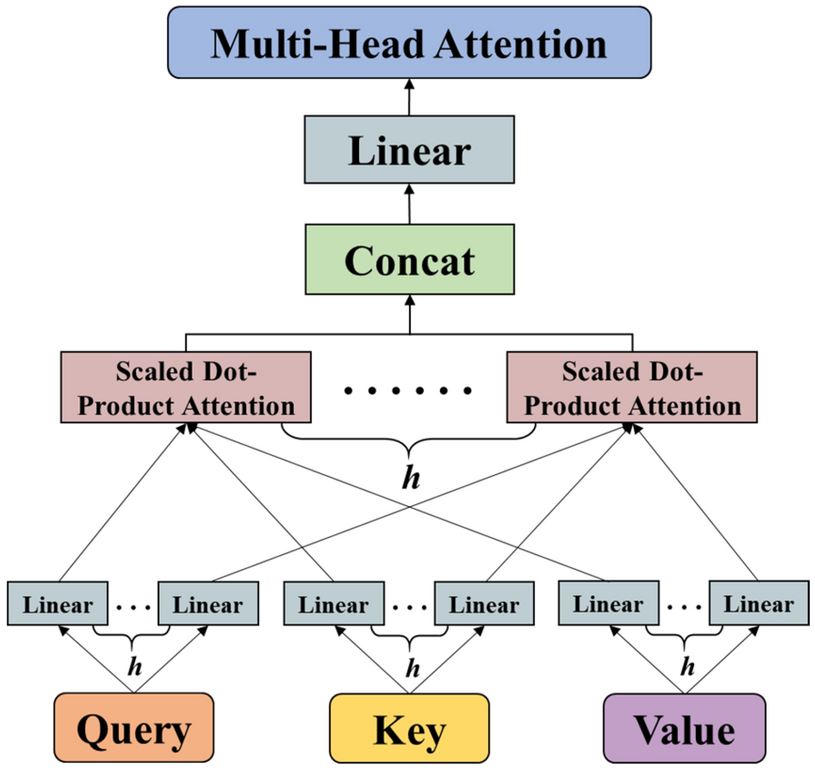

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0  # Ensure divisibility

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Key size per head

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.attention = ScaledDotProductAttention(self.d_k)

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.shape[0]

        # Linear projections
        Q = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Apply Scaled Dot-Product Attention
        attn_output, attn_weights = self.attention(Q, K, V, mask)

        # Concatenate heads and apply final linear layer
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(attn_output)

        return output, attn_weights


In [ ]:
# Hyperparameters
d_model = 64  # Embedding dimension
num_heads = 8  # Number of attention heads
seq_len = 10  # Sequence length
batch_size = 2  # Batch size

# Sample Input
Q = torch.rand(batch_size, seq_len, d_model)
K = torch.rand(batch_size, seq_len, d_model)
V = torch.rand(batch_size, seq_len, d_model)

# Define Multi-Head Attention
mha = MultiHeadAttention(d_model, num_heads)
output, attn_weights = mha(Q, K, V)

print("Output Shape:", output.shape)  # Expected: (batch_size, seq_len, d_model)
print("Attention Weights Shape:", attn_weights.shape)  # Expected: (batch_size, num_heads, seq_len, seq_len)


Output Shape: torch.Size([2, 10, 64])
Attention Weights Shape: torch.Size([2, 8, 10, 10])


`torch.nn.MultiheadAttention`

Output Shape: torch.Size([2, 10, 64])
Attention Weights Shape: torch.Size([2, 10, 10])


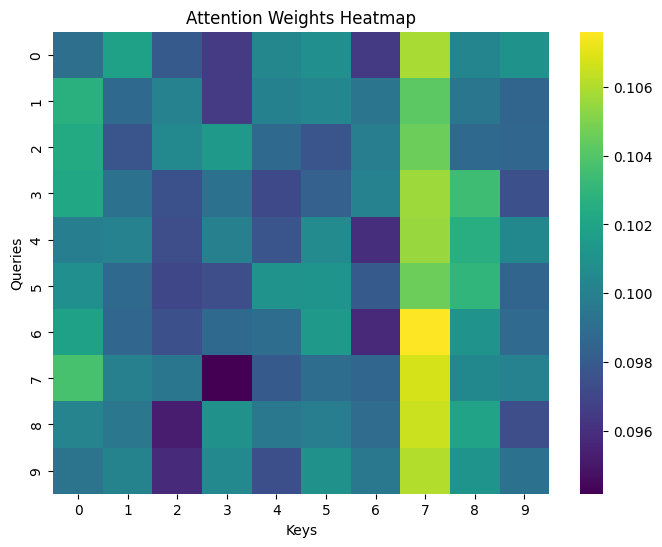

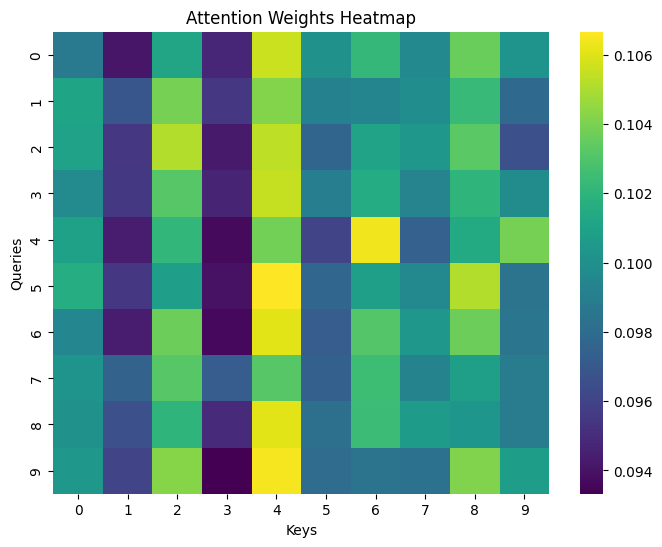

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# Hyperparameters
d_model = 64   # Embedding dimension
num_heads = 8  # Number of attention heads
seq_len = 10   # Sequence length
batch_size = 2 # Batch size

# Multi-Head Attention Layer
mha = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, batch_first=True)

# Sample Input (Query, Key, Value)
# Q = torch.rand(batch_size, seq_len, d_model)
# K = torch.rand(batch_size, seq_len, d_model)
# V = torch.rand(batch_size, seq_len, d_model)

# Apply Multi-Head Attention
output, attn_weights = mha(Q, K, V, need_weights=True)

print("Output Shape:", output.shape)  # Expected: (batch_size, seq_len, d_model)
print("Attention Weights Shape:", attn_weights.shape)  # Expected: (batch_size, seq_len, seq_len)

def plot_attention_weights(attn_weights, seq_len, batch_idx=0):
    """Visualize the attention weights for a single head."""
    attn_weights = attn_weights[batch_idx].detach().numpy()  # Select first batch item

    plt.figure(figsize=(8, 6))
    sns.heatmap(attn_weights, cmap="viridis", annot=False, xticklabels=range(seq_len), yticklabels=range(seq_len))
    plt.xlabel("Keys")
    plt.ylabel("Queries")
    plt.title("Attention Weights Heatmap")
    plt.show()

# Visualize attention weights - batch_idx=0
plot_attention_weights(attn_weights, seq_len, batch_idx=0)


# Visualize attention weights - batch_idx=1
plot_attention_weights(attn_weights, seq_len, batch_idx=1)

### Masked Self-Attention

Masked Self-Attention is a variant of self-attention that prevents a model from attending to future tokens during training.

This is essential for autoregressive models like GPT (ChatGPT, LLaMA, Falcon, etc.) to ensure proper sequential generation.

**Why Do We Need Masked Self-Attention?**

- **Problem:** In language generation, a model `should not` peek ahead at `future words`.
- For example, when predicting the next word in:
  -  "The cat sat on the..."
  - The model should not see "mat" before generating it.

💡 **Solution:** Masked Attention forces the model to only use `past and present` words!

**How Does It Work?**

Masked self-attention builds on the scaled dot-product attention we covered earlier.

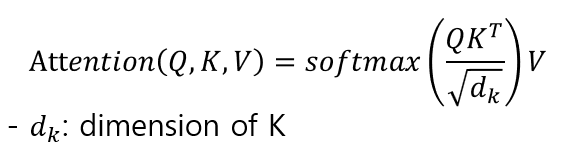

The difference is in the attention scores —we apply a `mask` before the softmax to block attention to future tokens.

**Masking (Hide Future Tokens)**

We apply a mask matrix that sets future words to -∞:

    Masked Scores =  s_11  −∞    −∞    −∞
                     s_21  s_22  −∞    −∞
                     s_31  s_32  s_33  −∞
                     s_41  s_42  s_43  s_44

💡 Effect? The model only attends to past and current tokens.


**Apply Softmax (Zero Probability for Masked Values)**

    Attention Weights = softmax( Masked Scores/√d_k )

The -∞ values turn into 0 probabilities, ensuring that future words are ignored.

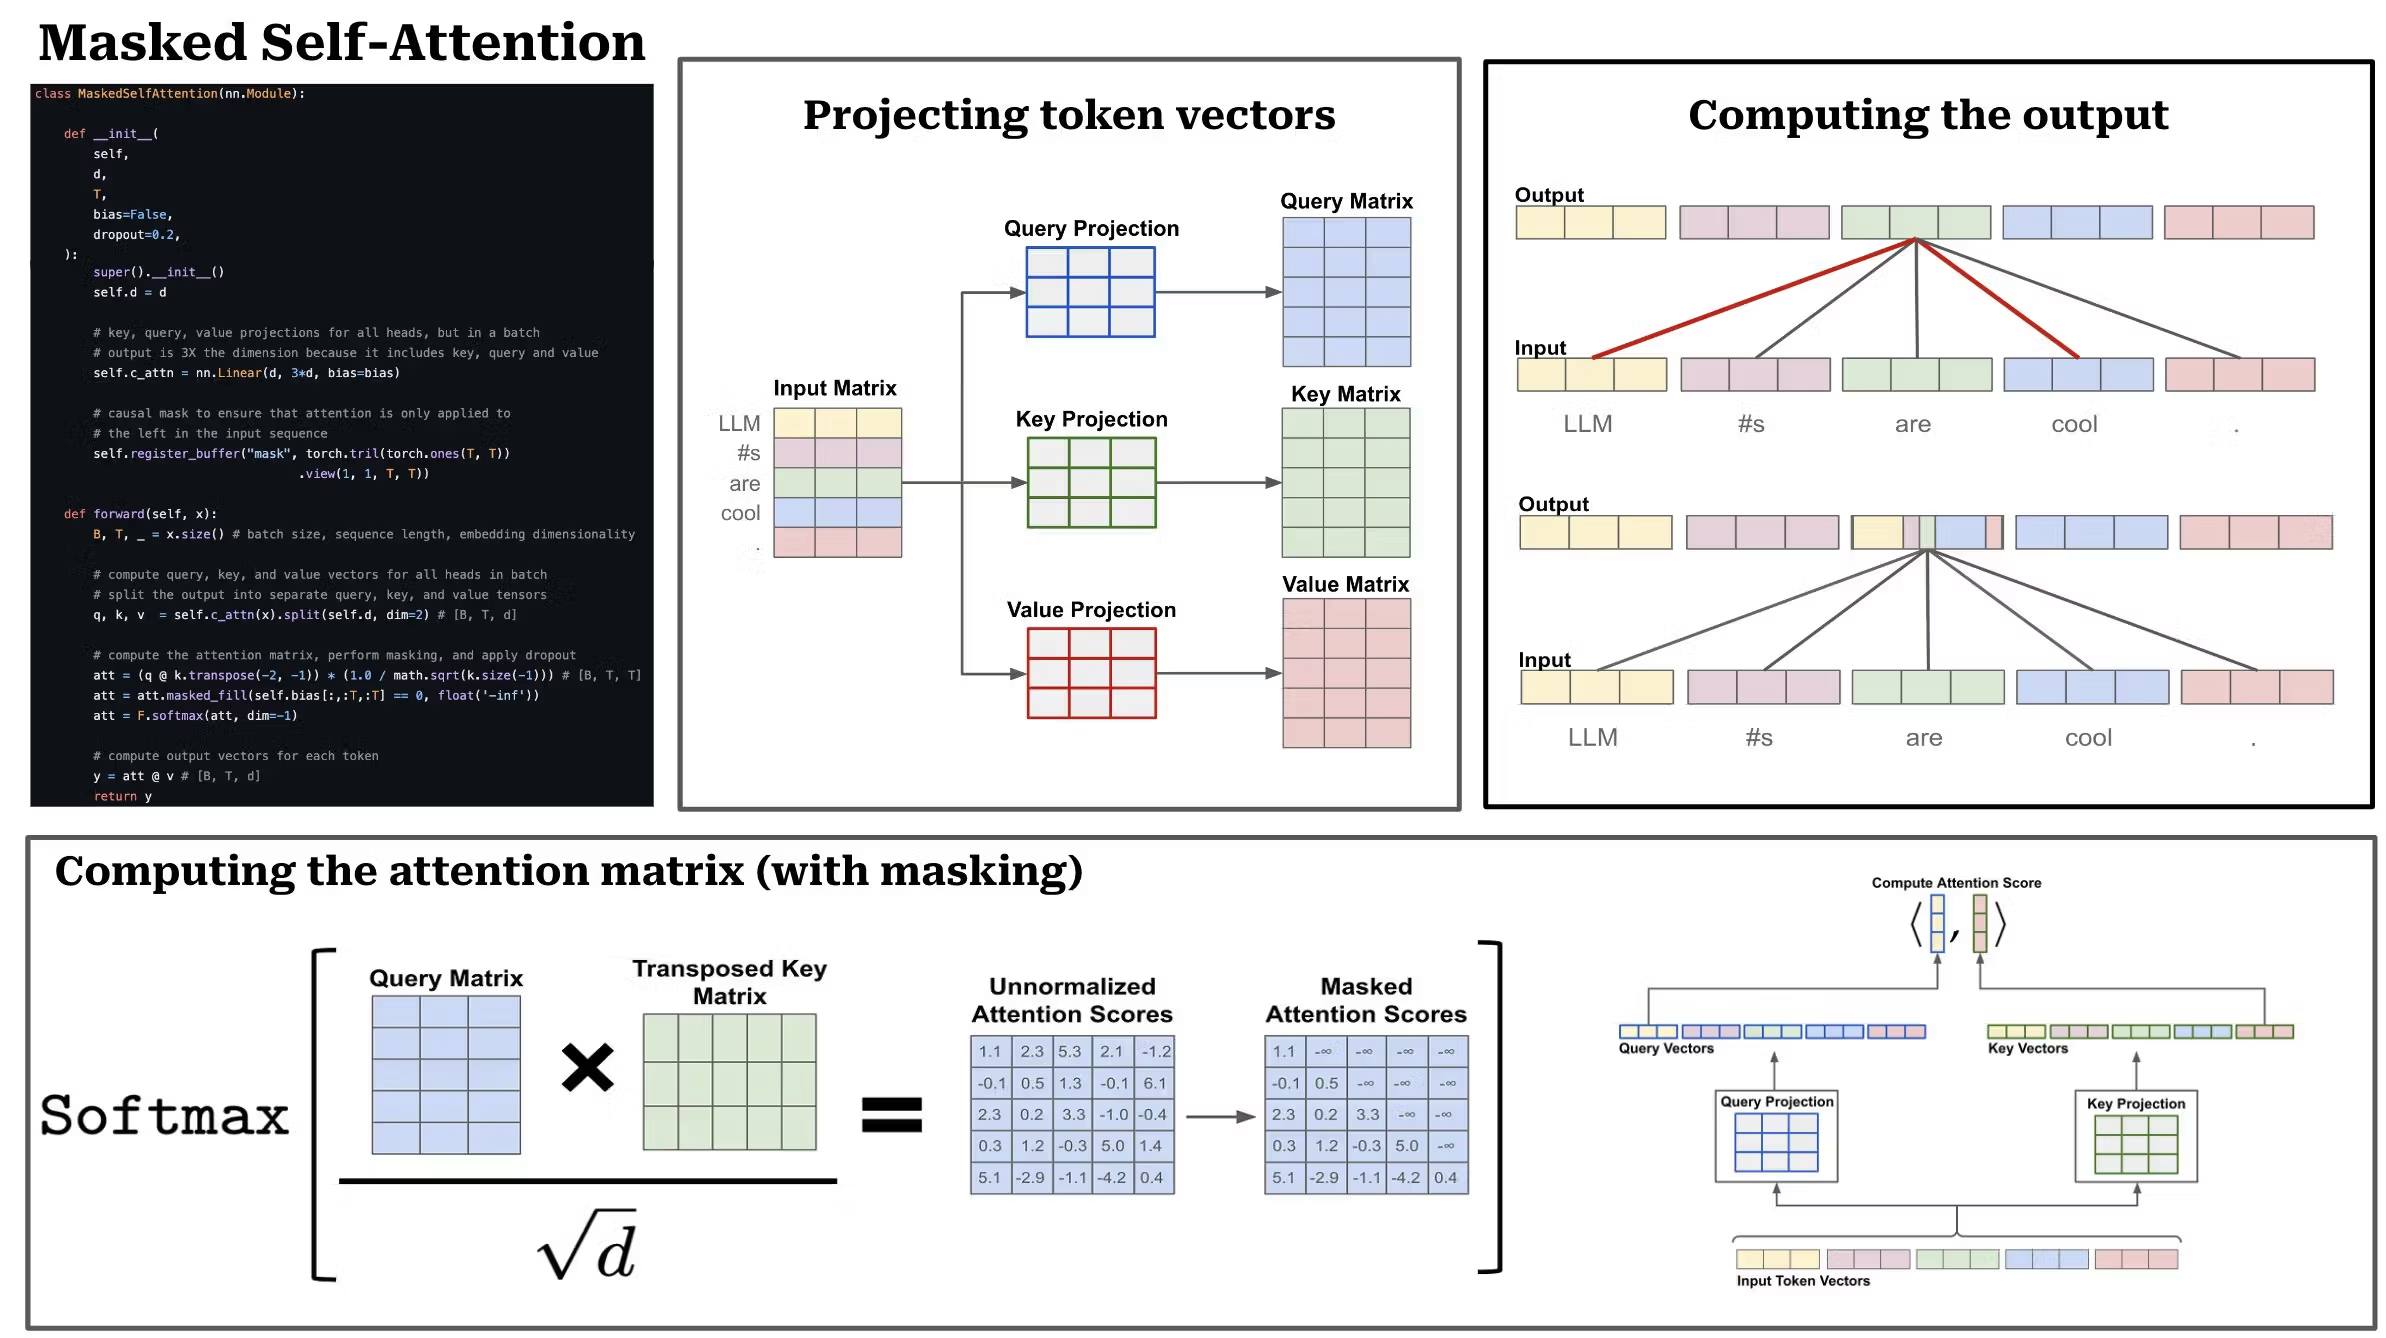

In [ ]:
import torch
import torch.nn as nn
import math

def masked_attention(query, key, value, mask=None):
    """
    Compute scaled dot-product attention with optional masking.
    Args:
        query: (batch_size, n_heads, seq_len, d_k)
        key: (batch_size, n_heads, seq_len, d_k)
        value: (batch_size, n_heads, seq_len, d_v)
        mask: (seq_len, seq_len) or broadcastable
    Returns:
        output: (batch_size, n_heads, seq_len, d_v)
    """
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)  # (batch, heads, seq_len, seq_len)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))  # Apply mask

    attn_weights = torch.softmax(scores, dim=-1)  # (batch, heads, seq_len, seq_len)
    output = torch.matmul(attn_weights, value)    # (batch, heads, seq_len, d_v)
    return output

# Example usage
batch_size, n_heads, seq_len, d_k = 1, 1, 3, 64
query = torch.randn(batch_size, n_heads, seq_len, d_k)
key = torch.randn(batch_size, n_heads, seq_len, d_k)
value = torch.randn(batch_size, n_heads, seq_len, d_k)

# Create a lower triangular mask (1s for allowed positions, 0s for masked)
mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0).unsqueeze(0)  # (1, 1, seq_len, seq_len)

output = masked_attention(query, key, value, mask)
print(output.shape)  # [1, 1, 3, 64]

torch.Size([1, 1, 3, 64])


Key points

- Used in autoregressive models like GPT to ensure correct text generation.
- Applies a mask to hide future words, forcing left-to-right processing.
- Essential for causal language modeling (next-word prediction).

## Transformer Architecture Overview

**Encoder and Decoder**

The Transformer is designed for sequence-to-sequence tasks (e.g., translating "Hola" to "Hello").

It has two main parts:

1. Encoder: Processes the input sequence into a rich, contextual representation.
2. Decoder: Generates the output sequence, step-by-step, using the encoder’s output.

Both are stacks of identical layers (typically 6 each in the original paper), and they rely entirely on attention mechanisms and feed-forward networks—no recurrence or convolutions here!

**1. Input Embedding and Positional Encoding**

- **Input Embedding:** Each token (word or subword) is converted into a dense vector (e.g., 512 dimensions) via an embedding layer.
- **Positional Encoding:** Since Transformers don’t process tokens sequentially, we add positional information to the embeddings. These are fixed or learned vectors that encode the position of each token (e.g., 1st, 2nd, 3rd).

Formula: For position pos and dimension i:
- PE(pos, 2i) = sin(pos/(10000^(2i/d_model))),
- PE(pos,2i+1)=cos(pos/(10000^(2i/d_model)))

Result: Input to the model is X = Embedding+Positional Encoding.

**2. Encoder**

- Number of Layers: N (e.g., 6 in the original).
- Each Layer Has Two Sub-Layers:
  1. Multi-Head Self-Attention:
    - Tokens attend to all other tokens in the input sequence.
    - Multiple heads (e.g., 8) capture different relationships.
    - Output is a contextualized representation of each token.
  2. Feed-Forward Neural Network (FFN):
    - A position-wise, fully connected network applied independently to each token.
    - Typically: FFN(x) = max(0,xW1+b1)W2+b2 (two layers with ReLU).
    - Add & Norm: Each sub-layer has a residual connection (x + SubLayer(x)) followed by layer normalization (LayerNorm(x+SubLayer(x))).

    
    Input → Multi-Head Attention → Add & Norm → Feed-Forward → Add & Norm → Output (passed to next layer or decoder).

**3. Decoder**

- Number of Layers: Also N (e.g., 6).
- Each Layer Has Three Sub-Layers:
  1. Masked Multi-Head Self-Attention:
    - Like the encoder’s self-attention, but "masked" so each token only attends to previous positions (for autoregressive generation).
    - Masking sets future token scores to −∞ before softmax.
  2. Multi-Head Cross-Attention:
    - Decoder attends to the encoder’s final output (keys and values from the encoder, queries from the decoder).
    - Aligns input and output sequences (e.g., "Hola" informs "Hello").
  3. Feed-Forward Neural Network:
    - Same as in the encoder.
    - Add & Norm: Same residual connections and normalization after each sub-layer.

Flow:

    Decoder Input → Masked Self-Attention → Add & Norm → Cross-Attention → Add & Norm → Feed-Forward → Add & Norm → Output.

**4. Output Layer**

- The decoder’s final output goes through a linear layer (to vocab size) and softmax to predict the next token.
- During training, it predicts the entire output sequence at once; during inference, it generates one token at a time.

    Attention Everywhere: Self-attention in the encoder, masked self-attention in the decoder, and cross-attention to connect them.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0

        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.shape[0]

        Q = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attn_weights, V)

        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        return self.W_o(output)

class FeedForwardNetwork(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForwardNetwork(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = self.norm1(x + self.dropout(self.self_attn(x, x, x, mask)))
        x = self.norm2(x + self.dropout(self.ffn(x)))
        return x

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForwardNetwork(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        x = self.norm1(x + self.dropout(self.self_attn(x, x, x, tgt_mask)))
        x = self.norm2(x + self.dropout(self.cross_attn(x, enc_output, enc_output, src_mask)))
        x = self.norm3(x + self.dropout(self.ffn(x)))
        return x

class Transformer(nn.Module):
    def __init__(self, d_model, num_heads, num_layers, d_ff, vocab_size, max_len, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)

        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.decoder_layers = nn.ModuleList([
            TransformerDecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])

        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        src = self.positional_encoding(self.embedding(src))
        tgt = self.positional_encoding(self.embedding(tgt))

        for layer in self.encoder_layers:
            src = layer(src, src_mask)

        for layer in self.decoder_layers:
            tgt = layer(tgt, src, src_mask, tgt_mask)

        return self.fc_out(tgt)


# Hyperparameters
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
vocab_size = 10000
max_len = 100
dropout = 0.1

# Model Initialization
transformer = Transformer(d_model, num_heads, num_layers, d_ff, vocab_size, max_len, dropout)

# Dummy Inputs
src = torch.randint(0, vocab_size, (2, max_len))  # (batch_size, seq_len)
tgt = torch.randint(0, vocab_size, (2, max_len))

# Forward Pass
output = transformer(src, tgt)
print("Output Shape:", output.shape)  # Expected: (batch_size, seq_len, vocab_size)

## Attention Mechanisms

### Cross-Attention

Cross-attention is an attention mechanism where the queries come from one sequence (the decoder’s current output), while the keys and values come from another sequence (the encoder’s output).

* It is widely used in multi-modal models (e.g., text-to-image, speech-to-text), Transformers, and generative AI models like Stable Diffusion, DALL·E, and T5.

**Difference from Self-Attention:**

- Self-Attention: A sequence attends to itself (e.g., BERT, GPT).
- Cross-Attention: One sequence attends to another sequence (e.g., text attending to an image).

**How Does Cross-Attention Work?**

**1. Define Query, Key, and Value (Q, K, V)**
- Query (Q) → Comes from one sequence (e.g., text in text-to-image generation).
- Key (K) & Value (V) → Come from another sequence (e.g., image embeddings).

**Where Does It Fit in the Transformer?**

- Decoder Layer: Cross-attention is the second sub-layer in each decoder layer (after masked self-attention, before the feed-forward network).

**2. Compute Attention Scores:**
- Just like self-attention, we compute similarity scores between Q and K.

**3. Apply Softmax to Get Attention Weights**
- The higher the weight, the more the model focuses on that part of K & V.

**4. Compute Final Output**
- Output = Attention Weights×V
- This output represents information from the other sequence based on relevance.

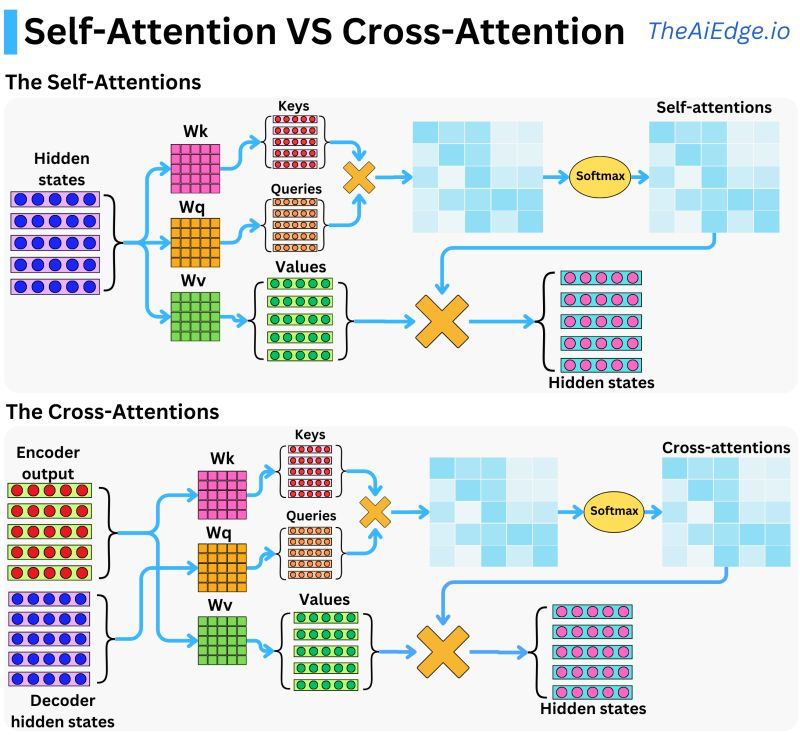

In [ ]:
import torch
import torch.nn.functional as F

def cross_attention(Q, K, V):
    d_k = Q.shape[-1]  # Key dimension
    scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k))

    # Apply softmax to get attention weights
    attention_weights = F.softmax(scores, dim=-1)

    # Compute attention output
    output = torch.matmul(attention_weights, V)
    return output, attention_weights

# Example: Text queries an image embedding (cross-attention)
Q = torch.rand(3, 64)  # 3 text embeddings
K = torch.rand(5, 64)  # 5 image embeddings
V = torch.rand(5, 64)  # 5 image value vectors

output, attn_weights = cross_attention(Q, K, V)
print("Output Shape:", output.shape)
print("Attention Weights Shape:", attn_weights.shape)

### Causal Attention

Causal Attention ensures that each token can only attend to past and present tokens, never the future ones.

This is essential for autoregressive models like GPT, LLaMA, Falcon, and Claude, where text is generated one token at a time.

Why Do We Need Causal Attention?

💡 Problem:

- In language modeling, predicting the next word should not depend on future words.
- If we allow tokens to see future tokens, the model would "cheat" by knowing what's coming next.

💡 Solution: Use a Mask!

- Causal Attention masks future tokens so each token can only look backward.
- This forces the model to learn sequential dependencies without peeking ahead.

**How Does Causal Attention Work?**

A triangular mask is applied so each token can only attend to previous tokens:


    Mask =  1   0   0   0
            1   1   0   0
            1   1   1   0
            1   1   1   1

- 1 → Token is visible
- 0 → Token is masked (-∞ in logits)

The result? Tokens never attend to the future!

Implemented with a simple upper-triangular mask in PyTorch.

In [ ]:
import torch
import torch.nn.functional as F

def causal_attention(Q, K, V):
    d_k = Q.shape[-1]  # Key dimension
    scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k))

    # Create a causal mask (upper triangular matrix)
    mask = torch.triu(torch.ones(scores.shape), diagonal=1)
    scores = scores.masked_fill(mask == 1, float('-inf'))  # Apply -inf to future tokens

    # Apply softmax to get attention weights
    attention_weights = F.softmax(scores, dim=-1)

    # Compute attention output
    output = torch.matmul(attention_weights, V)
    return output, attention_weights

# Example: 4 tokens, 64-dim embeddings
Q = torch.rand(4, 64)
K = torch.rand(4, 64)
V = torch.rand(4, 64)

output, attn_weights = causal_attention(Q, K, V)
print("Attention Weights:\n", attn_weights)

### Global vs. Local Attention

**What is Global Attention?**
- Global attention means every token in the sequence attends to all other tokens (or `all tokens` in another sequence, for cross-attention).
- Each word/token gets a `complete context` from the entire sequence.
- More computationally expensive (scales as `O(n²)` with sequence length).
- Used in BERT, GPT, T5, and full Transformers.

**Example Use Case:**

- Machine Translation → Every word should consider the entire input sequence.
- Text Summarization → The model should see the full document.
- Vision Transformers (ViTs) → Each image patch attends to all others.

**What is Local Attention?**
- Local Attention restricts each token to attend only to nearby tokens (a `fixed window size`).
- Mask future tokens beyond a certain window size w.
- Complexity: Drops from O(n²) (global) to `O(n⋅w)`, where w is the window size.
- Useful for long sequences like documents, books, or long videos.
- Used in Longformer, BigBird, Reformer, and efficient Transformers.

**Example Use Case:**

- Long Text Processing → Process 10,000+ tokens efficiently.
- Speech Recognition → Each frame should attend to surrounding frames.
- Bioinformatics (DNA sequences) → Local patterns matter more than global context.

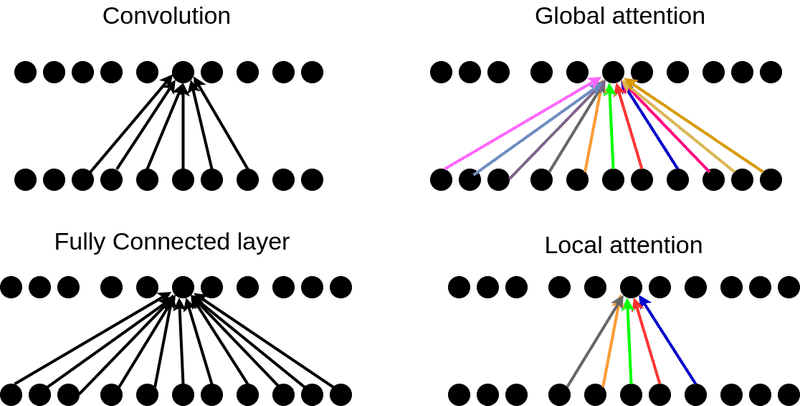

In [ ]:
import torch
import torch.nn.functional as F

def local_attention(Q, K, V, window_size=3):
    d_k = Q.shape[-1]  # Key dimension
    scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k))

    # Create a local attention mask (restricts to window size)
    mask = torch.ones(scores.shape) * float('-inf')
    for i in range(scores.shape[-1]):
        start, end = max(0, i - window_size), min(scores.shape[-1], i + window_size + 1)
        mask[i, start:end] = 0  # Allow only local window

    # Apply mask
    scores = scores + mask

    # Compute softmax
    attention_weights = F.softmax(scores, dim=-1)

    # Compute output
    output = torch.matmul(attention_weights, V)
    return output, attention_weights

# Example: 6 tokens, 64-dim embeddings, window size = 2
Q = torch.rand(6, 64)
K = torch.rand(6, 64)
V = torch.rand(6, 64)

output, attn_weights = local_attention(Q, K, V, window_size=2)
print("Attention Weights:\n", attn_weights)

### Sparse Attention

Sparse Attention is designed to reduce the quadratic complexity of traditional Self-Attention in Transformers.

- It's crucial for scaling large models (GPT-4, Mistral, Falcon, LLaMA 2) and handling long sequences efficiently.

**Why Sparse Attention?**
- Self-Attention Complexity: O(N**2) → Bottleneck for long sequences
- Sparse Attention Complexity: O(NlogN) or O(N)
- Memory & Compute Savings: Enables 100K+ token context lengths

**Sparse Attention Techniques**

**1. Fixed Sparse Patterns**

Predefined patterns that limit which tokens attend to others:
- Strided Attention – Attend only to every k-th token
- Local Window Attention – Attend to a fixed-size neighborhood
- Dilated Attention – Attend with gaps (e.g., every 2nd, 4th token)

**2. Learnable Sparse Patterns**
- Dynamic Sparse Attention (Sparsity Adaptive Models) – Learn which tokens should interact
- Top-k Attention – Attend only to the most relevant k tokens
- Sinkhorn Attention – Uses sorting to reorder tokens for efficient sparsity

**3. Memory-Efficient Sparse Attention**
- Reformer (LSH Attention) – Clusters similar tokens using Locality-Sensitive Hashing
- BigBird (Global + Local + Random Attention) – Hybrid approach for long documents
- Linformer (Low-Rank Projection) – Reduces tokens before computing attention
- Longformer (Sliding Window Attention) – Uses fixed local attention instead of global

### Attentions in Vision Models

Attention mechanisms have also been integrated into computer vision architectures.
- Squeeze-and-Excitation Networks (SE-Net) – Channel-wise attention for CNNs
- Convolutional Block Attention Module (CBAM) – Spatial & channel attention for CNNs
- Non-Local Neural Networks – Applies self-attention in vision tasks
- Vision Transformers (ViT) – Adapts self-attention to image patches
- Swin Transformer – Uses hierarchical windowed self-attention for efficient image processing
- Cross-Attention Image Generation (DALLE-2, Stable Diffusion) – Maps text embeddings to image pixels

In [ ]:
import torch
import torch.nn as nn

# Squeeze-and-Excitation Networks (SE-Net) – Channel-wise Attention
class SEAttention(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEAttention, self).__init__()
        # Squeeze: Global average pooling reduces spatial dims to 1x1
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # Excitation: Two FC layers to model channel dependencies
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()  # Input: [batch, channels, height, width]
        # Squeeze: [b, c, 1, 1]
        y = self.avg_pool(x).view(b, c)  # Global avg pool -> [b, c]
        # Excitation: [b, c] -> [b, c]
        y = self.fc(y).view(b, c, 1, 1)  # FC layers + sigmoid
        # Scale input channels
        return x * y  # Element-wise multiplication

# Example usage
x = torch.randn(2, 64, 32, 32)  # [batch, channels, H, W]
se = SEAttention(channel=64)
out = se(x)
print(out.shape)  # [2, 64, 32, 32]

In [ ]:
import torch
import torch.nn as nn

# Convolutional Block Attention Module (CBAM) – Spatial & Channel Attention
class CBAM(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CBAM, self).__init__()
        # Channel attention
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

        # Spatial attention
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)

    def forward(self, x):
        b, c, h, w = x.size()

        # Channel attention
        avg_out = self.fc(self.avg_pool(x).view(b, c)).view(b, c, 1, 1)
        max_out = self.fc(self.max_pool(x).view(b, c)).view(b, c, 1, 1)
        channel_att = self.sigmoid(avg_out + max_out)
        x = x * channel_att

        # Spatial attention
        avg_spatial = torch.mean(x, dim=1, keepdim=True)  # [b, 1, h, w]
        max_spatial, _ = torch.max(x, dim=1, keepdim=True)  # [b, 1, h, w]
        spatial_in = torch.cat([avg_spatial, max_spatial], dim=1)  # [b, 2, h, w]
        spatial_att = self.sigmoid(self.conv(spatial_in))  # [b, 1, h, w]
        x = x * spatial_att

        return x

# Example usage
x = torch.randn(2, 64, 32, 32)
cbam = CBAM(channel=64)
out = cbam(x)
print(out.shape)  # [2, 64, 32, 32]

In [ ]:
import torch
import torch.nn as nn

# Non-Local Neural Networks – Self-Attention for Vision
# Applies global self-attention to capture long-range dependencies in feature maps.
class NonLocalBlock(nn.Module):
    def __init__(self, in_channels):
        super(NonLocalBlock, self).__init__()
        self.inter_channels = in_channels // 2
        # Theta, Phi, G: 1x1 convs to reduce dimensionality
        self.theta = nn.Conv2d(in_channels, self.inter_channels, kernel_size=1)
        self.phi = nn.Conv2d(in_channels, self.inter_channels, kernel_size=1)
        self.g = nn.Conv2d(in_channels, self.inter_channels, kernel_size=1)
        # Output conv
        self.out_conv = nn.Conv2d(self.inter_channels, in_channels, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        b, c, h, w = x.size()
        n = h * w  # Number of spatial locations

        # Theta: Query [b, c/2, h, w] -> [b, c/2, n]
        theta = self.theta(x).view(b, self.inter_channels, -1)
        # Phi: Key [b, c/2, h, w] -> [b, c/2, n]
        phi = self.phi(x).view(b, self.inter_channels, -1).permute(0, 2, 1)  # [b, n, c/2]
        # G: Value [b, c/2, h, w] -> [b, c/2, n]
        g = self.g(x).view(b, self.inter_channels, -1)

        # Attention: [b, n, n]
        attention = self.softmax(torch.bmm(theta.permute(0, 2, 1), phi))  # QK^T
        # Weighted sum: [b, n, c/2]
        out = torch.bmm(attention, g.permute(0, 2, 1)).permute(0, 2, 1)  # Att * V
        out = out.view(b, self.inter_channels, h, w)
        out = self.out_conv(out)  # Restore channels

        return x + out  # Residual connection

# Example usage
x = torch.randn(2, 64, 32, 32)
nl = NonLocalBlock(in_channels=64)
out = nl(x)
print(out.shape)  # [2, 64, 32, 32]

In [ ]:
import torch
import torch.nn as nn

# Vision Transformer (ViT) – Self-Attention on Image Patches
# Splits images into patches, treats them as tokens, and applies Transformer self-attention.
class ViTSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(ViTSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)  # Q, K, V in one
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        b, n, d = x.size()  # [batch, num_patches+1, embed_dim]
        qkv = self.qkv(x).reshape(b, n, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # [b, heads, n, head_dim]

        attn = (q @ k.transpose(-2, -1)) * self.scale  # [b, heads, n, n]
        attn = self.softmax(attn)
        out = (attn @ v).transpose(1, 2).reshape(b, n, d)  # [b, n, embed_dim]
        out = self.proj(out)
        return out

# Example usage (assuming patches are already embedded)
x = torch.randn(2, 197, 768)  # [batch, 196 patches + 1 cls token, embed_dim]
vit_attn = ViTSelfAttention(embed_dim=768, num_heads=12)
out = vit_attn(x)
print(out.shape)  # [2, 197, 768]

In [ ]:
import torch
import torch.nn as nn

# Swin Transformer – Hierarchical Windowed Self-Attention
# Uses shifted windows for local attention, hierarchically reducing resolution.
class SwinWindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads):
        super(SwinWindowAttention, self).__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        b, n, d = x.size()  # [batch * num_windows, window_size * window_size, dim]
        qkv = self.qkv(x).reshape(b, n, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # [b, heads, n, head_dim]

        attn = (q @ k.transpose(-2, -1)) * self.scale  # [b, heads, n, n]
        if mask is not None:
            attn = attn + mask  # Apply window mask if shifted
        attn = self.softmax(attn)
        out = (attn @ v).transpose(1, 2).reshape(b, n, d)
        out = self.proj(out)
        return out

# Example usage (simplified, assumes windowed input)
x = torch.randn(8, 49, 96)  # [batch * num_windows, window_size^2, dim]
swin_attn = SwinWindowAttention(dim=96, window_size=7, num_heads=3)
out = swin_attn(x)
print(out.shape)  # [8, 49, 96]

In [ ]:
import torch
import torch.nn as nn

# Cross-Attention for Image Generation (e.g., DALL-E 2, Stable Diffusion)
# Maps text embeddings to image features using cross-attention.
class CrossAttention(nn.Module):
    def __init__(self, query_dim, context_dim, num_heads):
        super(CrossAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = query_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.query = nn.Linear(query_dim, query_dim)
        self.key = nn.Linear(context_dim, query_dim)
        self.value = nn.Linear(context_dim, query_dim)
        self.proj = nn.Linear(query_dim, query_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, context):
        b, n, d = x.size()  # Image features: [batch, num_pixels, query_dim]
        b, m, c = context.size()  # Text embeddings: [batch, num_tokens, context_dim]

        q = self.query(x).view(b, n, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = self.key(context).view(b, m, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = self.value(context).view(b, m, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        attn = (q @ k.transpose(-2, -1)) * self.scale  # [b, heads, n, m]
        attn = self.softmax(attn)
        out = (attn @ v).transpose(1, 2).reshape(b, n, -1)  # [b, n, query_dim]
        out = self.proj(out)
        return out

# Example usage
x = torch.randn(2, 1024, 256)  # Image features [batch, pixels, dim]
context = torch.randn(2, 77, 512)  # Text embeddings [batch, tokens, dim]
cross_attn = CrossAttention(query_dim=256, context_dim=512, num_heads=8)
out = cross_attn(x, context)
print(out.shape)  # [2, 1024, 256]

## Vision Transformers (ViT) & Hybrid Models

    ViT Architecture (Patch Embeddings, MLP Heads)
    ✔ Hybrid CNN-Transformer Models (Swin Transformer, ConvNext)
    ✔ Self-Supervised Learning with Vision Transformers (DINO, MAE)

### Vision Transformer (ViT)

A groundbreaking architecture that adapts the Transformer model—originally designed for NLP—to computer vision tasks.

- Introduced in the 2020 paper "`An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale`" by Dosovitskiy et al., ViT replaces convolutions with `self-attention over image patches`, achieving `state-of-the-art performance on image classification`.

`Key Idea:` Images are sequences too—split them into patches and let self-attention do the heavy lifting.

**ViT Architecture Overview**

1. Patch Embedding:
  - Split the image into non-overlapping patches.
  - Flatten each patch into a vector and project it to a fixed embedding dimension.

2. Positional Encoding:
  - Add learnable positional embeddings to retain spatial information (since self-attention is permutation-invariant).

3. Class Token:
  - Prepend a learnable token to the sequence for classification (inspired by BERT’s [CLS] token).

4. Transformer Encoder:
  - Stack of Transformer layers with multi-head self-attention and feed-forward networks.

5. Classification Head:
  - Use the final class token’s representation for prediction.

Key Parameters (ViT-B/16 Example)

    Image Size: 224x224
    Patch Size: 16x16
    Embed Dim: 768
    Depth: 12 layers
    Num Heads: 12
    MLP Dim: 3072
    Num Patches:  (224*224/16)  = 196 + 1 (cls) = 197

In [ ]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        # Linear projection of patches: (patch_size * patch_size * in_channels) -> embed_dim
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # Positional embedding
        self.pos_embed = nn.Parameter(torch.zeros(1, self.n_patches + 1, embed_dim))

    def forward(self, x):
        b, c, h, w = x.size()  # [batch, channels, height, width]
        # Project patches to embeddings: [b, embed_dim, h/patch, w/patch]
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)  # [b, n_patches, embed_dim]

        # Add class token
        cls_tokens = self.cls_token.expand(b, -1, -1)  # [b, 1, embed_dim]
        x = torch.cat((cls_tokens, x), dim=1)  # [b, n_patches + 1, embed_dim]

        # Add positional embedding
        x = x + self.pos_embed  # [b, n_patches + 1, embed_dim]
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        b, n, d = x.size()  # [batch, n_patches + 1, embed_dim]
        qkv = self.qkv(x).reshape(b, n, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # [b, heads, n, head_dim]

        attn = (q @ k.transpose(-2, -1)) * self.scale  # [b, heads, n, n]
        attn = self.softmax(attn)
        attn = self.dropout(attn)
        out = (attn @ v).transpose(1, 2).reshape(b, n, d)  # [b, n, embed_dim]
        out = self.proj(out)
        out = self.dropout(out)
        return out

class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # Attention block
        attn_out = self.attn(x)
        x = self.norm1(x + attn_out)
        # MLP block
        mlp_out = self.mlp(x)
        x = self.norm2(x + mlp_out)
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=1000,
                 embed_dim=768, depth=12, num_heads=12, mlp_dim=3072, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.encoder = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # Patch embedding
        x = self.patch_embed(x)  # [b, n_patches + 1, embed_dim]
        # Transformer encoder
        for layer in self.encoder:
            x = layer(x)
        # Final norm
        x = self.norm(x)
        # Classification from cls token
        cls_output = x[:, 0]  # [b, embed_dim]
        out = self.head(cls_output)  # [b, num_classes]
        return out

# Example usage
x = torch.randn(2, 3, 224, 224)  # [batch, channels, height, width]
vit = VisionTransformer()
out = vit(x)
print(out.shape)  # [2, 1000]

### Swin Transformer

Swin Transformer (Shifted Window Transformer) is designed for vision tasks like classification, detection, and segmentation.
- Unlike ViT’s global self-attention over all patches, Swin uses local windowed attention with a shifted window mechanism to capture both local and cross-window interactions.
- It also builds a hierarchical feature representation, mimicking CNNs’ multi-scale nature.

**Core Innovations**

**1. Windowed Multi-Head Self-Attention (W-MSA)**

- Divide the image into non-overlapping windows (e.g., 7x7 patches).
- Apply self-attention within each window only, reducing complexity to
O(M^2) per window, where M is window size (e.g., 49).
- Total complexity: O(N⋅M), linear in the number of patches N.

**2. Shifted Window Multi-Head Self-Attention (SW-MSA)**

- Shift windows by half their size (e.g., 3-4 patches) in the next layer.
- Allows patches to interact across window boundaries, building global context over layers.
- Uses a cyclic shift and masking to handle shifted boundaries efficiently.

**3. Patch Merging**

- Between stages, merge 2x2 neighboring patches into one, halving spatial resolution and doubling channels (like CNN pooling).

**Swin Transformer Architecture**

1. Patch Splitting & Embedding – Converts images into patches
2. Hierarchical Feature Learning – Patch merging reduces resolution at each stage
3. Shifted Window Self-Attention (SW-MSA) – Efficient local self-attention
4. MLP Head – Performs final classification


Each Swin Transformer Block consists of:
1. Window-based Multi-Head Self-Attention (W-MSA) – Computes self-attention within windows
2. Shifted Window Multi-Head Self-Attention (SW-MSA) – Moves windows for better global interactions
3. MLP & LayerNorm – Enhances feature representation

## Transformers for Natural Language Processing (NLP)

    ✔ BERT (Masked Language Modeling, Fine-Tuning, Sentence Embeddings)
    ✔ GPT (Causal Language Modeling, Autoregressive Generation)
    ✔ T5 & BART (Sequence-to-Sequence Learning, Summarization)
    ✔ Transformers for Retrieval (ColBERT, Dense Passage Retrieval)

## Diffusion Transformers & Generative AI

    ✔ Denoising Diffusion Transformer (DiT) for Image Generation
    ✔ DALLE-2 & Stable Diffusion using Transformers
    ✔ Token-based Image Generation (VQ-VAE, CLIP + Transformers)

# Autoencoders

Autoencoders are a class of neural networks used for unsupervised learning, mainly for dimensionality reduction, feature extraction, anomaly detection, and generative tasks.

## What is an Autoencoder?

Undercomplete vs. Overcomplete Autoencoders

# GenAI

`Generative artificial intelligence`, often called generative AI or `gen AI`, is a type of AI that can `create new content` like conversations, stories, images, videos, and music.

Let's cover both fundamentals and advanced techniques.

Generative AI typically relies on deep learning techniques, particularly neural networks such as:

1. **Generative Adversarial Networks (GANs)** – A system with two neural networks (generator and discriminator) that compete to produce high-quality outputs.
2. **Variational Autoencoders (VAEs)** – A probabilistic approach that learns to encode and decode data, useful for image and text generation.
3. **Transformer Models (e.g., GPT, BERT, T5)** – These models use attention mechanisms to generate text, translate languages, or summarize information.
4. **Diffusion Models (e.g., Stable Diffusion, DALL·E 3)** – A newer approach that generates images by refining random noise into meaningful content.

## Fundamentals of Generative AI

### What is Artificial Intelligence (AI)?

Artificial Intelligence (AI) is a branch of computer science that enables machines to simulate human intelligence—learning, reasoning, problem-solving, perception, and language understanding.

AI can be categorized based on its capabilities and functionalities.

### Types of AI Based on Capabilities

AI is classified into three main types:

#### 1. Narrow AI (Weak AI)

- AI that is designed to `perform a specific task` with high efficiency.
- Capabilities: Cannot think beyond its trained scope.
- It follows pre-programmed rules and patterns.

Examples:

- Siri, Alexa, Google Assistant (Voice Recognition)
- ChatGPT, Bard, Claude (Natural Language Processing)
- Tesla’s Autopilot (Self-Driving AI)

#### 2. General AI (Strong AI)

AI that `possesses human-like cognitive abilities` and can perform any intellectual task a human can.

Capabilities:

- Understand, learn, and apply knowledge across different domains.
- Solve problems independently, `like a human`.
- Show self-awareness and emotions.

Examples: Currently, no real-world example exists. It is `still a research goal`.

Future Possibilities:
- A machine capable of autonomous reasoning & decision-making.
- AI that can learn new tasks without training.
- Potentially as intelligent as a human brain.

#### 3. Super AI (Artificial Superintelligence - ASI)

AI that `surpasses human intelligence` in all aspects, including reasoning, creativity, decision-making, and emotional intelligence.

Capabilities:

- Solve complex problems `beyond human capability`.
- Exhibit independent emotions and consciousness.
- Could lead to AI controlling its own development.

Examples: Purely theoretical. `No current system` is at this level.

Concerns & Risks:
- Ethical issues (AI dominance over humans).
- Potential existential risks (AI surpassing human control).
- Need for strict regulations (AI Safety & Alignment).

### What is Generative AI?

Generative AI refers to a category of artificial intelligence that can create new content, such as text, images, music, or even code, based on patterns it learns from existing data.

Unlike discriminative AI (which classifies or predicts), generative AI produces outputs that mimic the structure and style of its training data.

Discriminative vs. Generative Models

- Discriminative models classify data (e.g., CNNs, LSTMs).
- Generative models create new data (e.g., GANs, VAEs).

### Probability Distributions & Sampling

Generative models rely on `probability distributions` ***to learn patterns*** in data and generate new samples.

Understanding these distributions and sampling techniques is key to building AI models like VAEs, GANs, and Diffusion Models.

#### Probability Distributions

- A probability distribution describes how likely different outcomes are.
- Generative models learn these distributions and use them to generate new data.

Example:

- Gaussian (Normal) Distribution – Common in VAEs.
- Bernoulli Distribution – Binary data generation, Used in binary classification.
- Categorical Distribution – Used for text generation (word probabilities).

#### Sampling Techniques

- Monte Carlo Sampling – Randomized techniques - Used in VAEs, reinforcement learning, and Bayesian networks.
- Markov Chain Monte Carlo (MCMC) – Used in probabilistic models - Used in Bayesian deep learning and diffusion models.
- Top-k & Nucleus Sampling – Text generation strategies (GPT models).

### Latent Space Representation



It allows AI to learn meaningful representations of data and generate new content by manipulating these representations.

#### What is Latent Space?

- Latent space is a compressed, lower-dimensional representation of input data.
- Instead of storing raw pixel values or text embeddings, models learn a compact, `abstract representation` that captures the most important features.

**Why Latent Space?**

- Efficient dimensionality reduction.
- Captures semantic relationships in data.
- Enables smooth interpolations & transformations between data points.
- Used in image synthesis, style transfer, and data augmentation.

**Example:**

A latent space for human faces could have meaningful directions:
- One axis might represent smiling vs. neutral.
- Another axis could represent male vs. female.
- Moving along these directions generates new variations of faces.

#### Visualizing Latent Space

Latent space is often high-dimensional (e.g., 256D, 512D, 1024D), but we can visualize it in 2D/3D using:

- Principal Component Analysis (PCA)
- t-SNE (t-Distributed Stochastic Neighbor Embedding)
- UMAP (Uniform Manifold Approximation and Projection)

#### Latent Space in Different Generative Models

Latent space is a key concept in Generative AI, particularly in Autoencoders, VAEs, GANs, and Diffusion Models.

**Autoencoders**
- Encoders compress input into a latent representation.
- Decoders reconstruct data from latent space.
- Loss functions ensure meaningful latent structures.

**Variational Autoencoders (VAEs):**

- Instead of learning fixed latent representations, VAEs learn probability distributions.
- Used for image generation, anomaly detection, and synthetic data creation.

**GANs (Generative Adversarial Networks)**
- The Generator learns a mapping from random noise (latent space) to real data.
- The Discriminator helps in refining the mapping.
- Interpolation in latent space creates new, realistic outputs.

**Diffusion Models (Stable Diffusion, DALL·E 2)**
- Use latent diffusion instead of pixel-space diffusion.
- Convert images into a lower-dimensional latent space before applying noise.
- Reduces computation and improves quality.

## Generative Adversarial Networks (GANs)

`Generative modeling` is an unsupervised learning approach that involves automatically discovering and learning patterns in input data such that the model can be used to generate new examples from the original dataset.

GANs is a way of training a generative model by framing problem as a supervised learning problem with two sub-models.

There are two components of GANs:

1. Generator: It is trained to `generate new dataset`, for example in computer vision it generates new images from existing real world images.
2. Discriminator: It compares those images with some real world examples and classify `real and fake` images.

### Understanding GANs

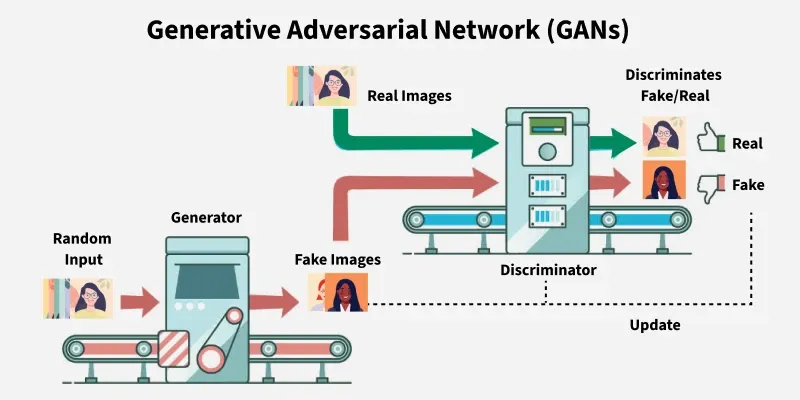

Generative Adversarial Networks (GANs) were introduced by Ian Goodfellow and his colleagues in 2014.

GAN’s architecture consists of two neural networks:

1. Generator: creates synthetic data from random noise to produce data so realistic that the discriminator cannot distinguish it from real data.
2. Discriminator: acts as a critic, evaluating whether the data it receives is real or fake.

#### Generator Model

The generator is a deep neural network that takes random noise as input to generate realistic data samples (e.g., images or text). It learns the underlying data distribution by adjusting its parameters through backpropagation.

The generator’s objective is to produce samples that the discriminator classifies as real.


The loss function is:

    J_G = − 1/m Σ log D(G(zi))

Where,

- J_G measure how well the generator is fooling the discriminator.
- log D(G(zi)) represents log probability of the discriminator being correct for generated samples.
- The generator aims to minimize this loss, encouraging the production of samples that the discriminator classifies as real logD(G(zi)), close to 1.

#### Discriminator Model

The discriminator acts as a binary classifier, distinguishing between real and generated data. It learns to improve its classification ability through training, refining its parameters to detect fake samples more accurately.

The discriminator reduces the negative log likelihood of correctly classifying both produced and real samples. This loss incentivizes the discriminator to accurately categorize generated samples as fake and real samples with the following equation:

    J_D = − 1/m Σ log D(xi) – 1/m Σ log(1–D(G(zi)))

- J_D assesses the discriminator’s ability to discern between produced and actual samples.
- The log likelihood that the discriminator will accurately categorize real data is represented by log D(xi).
- The log chance that the discriminator would correctly categorize generated samples as fake is represented by log(1–D(G(zi))).

#### MinMax Loss

The generator aims to minimize the loss, while the discriminator tries to maximize its classification accuracy.

### GAN implementation in PyTorch

a simple example that generates 2D data (e.g., points resembling a Gaussian distribution)

Overview

- Generator: Takes random noise and outputs synthetic 2D points.
- Discriminator: Classifies points as real (from a true dataset) or fake (from the generator).
- Goal: Train both networks so the generator produces points that mimic the real data distribution.

Epoch [0/10000] | D Loss: 1.4094 | G Loss: 0.6722
Epoch [500/10000] | D Loss: 1.1622 | G Loss: 0.9919
Epoch [1000/10000] | D Loss: 1.3973 | G Loss: 0.6273
Epoch [1500/10000] | D Loss: 1.5077 | G Loss: 0.6534
Epoch [2000/10000] | D Loss: 1.4680 | G Loss: 0.6205
Epoch [2500/10000] | D Loss: 1.2897 | G Loss: 0.8465
Epoch [3000/10000] | D Loss: 1.3699 | G Loss: 0.6893
Epoch [3500/10000] | D Loss: 1.3003 | G Loss: 0.7658
Epoch [4000/10000] | D Loss: 1.3861 | G Loss: 0.6769
Epoch [4500/10000] | D Loss: 1.3787 | G Loss: 0.7797
Epoch [5000/10000] | D Loss: 1.3867 | G Loss: 0.7114
Epoch [5500/10000] | D Loss: 1.4321 | G Loss: 0.6870
Epoch [6000/10000] | D Loss: 1.3884 | G Loss: 0.7140
Epoch [6500/10000] | D Loss: 1.4315 | G Loss: 0.6485
Epoch [7000/10000] | D Loss: 1.3883 | G Loss: 0.7469
Epoch [7500/10000] | D Loss: 1.3833 | G Loss: 0.7381
Epoch [8000/10000] | D Loss: 1.4188 | G Loss: 0.6557
Epoch [8500/10000] | D Loss: 1.4034 | G Loss: 0.6540
Epoch [9000/10000] | D Loss: 1.3956 | G Loss: 0.74

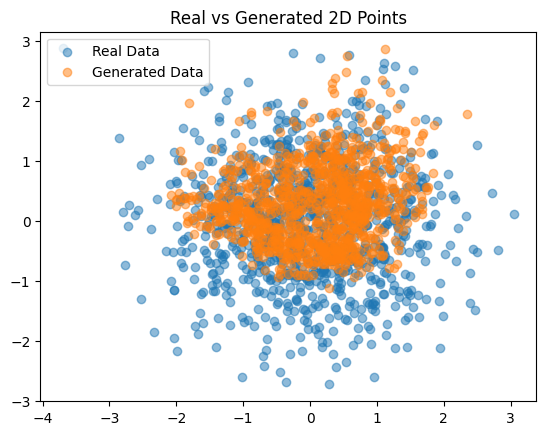

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
input_dim = 2      # Noise dimension
hidden_dim = 16    # Hidden layer size
output_dim = 2     # Output dimension (2D points)
batch_size = 64
num_epochs = 10000
lr = 0.001         # Learning rate

# Real data: Sample from a 2D Gaussian
real_data = torch.tensor(np.random.normal(0, 1, (1000, 2)), dtype=torch.float32)

# Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(output_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Output probability (0 = fake, 1 = real)
        )

    def forward(self, x):
        return self.model(x)

# Initialize models and optimizers
generator = Generator()
discriminator = Discriminator()
g_optimizer = optim.Adam(generator.parameters(), lr=lr)
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss

# Training Loop
for epoch in range(num_epochs):
    # 1. Train Discriminator
    d_optimizer.zero_grad()

    # Real data
    real_labels = torch.ones(batch_size, 1)
    idx = np.random.randint(0, real_data.size(0), batch_size)
    real_samples = real_data[idx]
    real_output = discriminator(real_samples)
    real_loss = criterion(real_output, real_labels)

    # Fake data
    noise = torch.randn(batch_size, input_dim)
    fake_samples = generator(noise)
    fake_labels = torch.zeros(batch_size, 1)
    fake_output = discriminator(fake_samples.detach())  # Detach to avoid backprop through generator
    fake_loss = criterion(fake_output, fake_labels)

    # Total discriminator loss
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()

    # 2. Train Generator
    g_optimizer.zero_grad()
    fake_output = discriminator(fake_samples)  # Recompute for generator backprop
    g_loss = criterion(fake_output, real_labels)  # Generator wants discriminator to think fakes are real
    g_loss.backward()
    g_optimizer.step()

    # Print progress
    if epoch % 500 == 0:
        print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# Visualize results
with torch.no_grad():
    noise = torch.randn(1000, input_dim)
    generated_data = generator(noise).numpy()
    plt.scatter(real_data[:, 0], real_data[:, 1], label="Real Data", alpha=0.5)
    plt.scatter(generated_data[:, 0], generated_data[:, 1], label="Generated Data", alpha=0.5)
    plt.legend()
    plt.title("Real vs Generated 2D Points")
    plt.show()

### GAN implementation in PyTorch

to generate realistic images using the CIFAR-10 dataset

Overview

- Dataset: CIFAR-10 (60,000 32x32x3 images across 10 classes).
- Generator: Takes random noise and upsamples it into a 32x32x3 image.
- Discriminator: Evaluates whether an image is real (from CIFAR-10) or fake (from the generator).
- Goal: Train the GAN to generate plausible CIFAR-10-like images.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
latent_dim = 100        # Size of the noise vector
image_channels = 3      # RGB images
hidden_dim = 64         # Base feature size for convolutional layers
image_size = 32         # CIFAR-10 image size (32x32)
batch_size = 64
num_epochs = 50
lr = 0.0002             # Learning rate (common for GANs)
beta1 = 0.5             # Adam optimizer parameter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, hidden_dim * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.ReLU(True),
            # 4x4
            nn.ConvTranspose2d(hidden_dim * 8, hidden_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.ReLU(True),
            # 8x8
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),
            # 16x16
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
            # 32x32
            nn.ConvTranspose2d(hidden_dim, image_channels, 4, 1, 0, bias=False),
            nn.Tanh()  # Output range [-1, 1]
            # 32x32x3
        )

    def forward(self, x):
        return self.main(x)

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: 32x32x3
            nn.Conv2d(image_channels, hidden_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 16x16
            nn.Conv2d(hidden_dim, hidden_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 8x8
            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 4x4
            nn.Conv2d(hidden_dim * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Output probability (0 = fake, 1 = real)
            # 1x1
        )

    def forward(self, x):
        return self.main(x)

# Initialize models and move to device
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Weight initialization (per DCGAN paper)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

generator.apply(weights_init)
discriminator.apply(weights_init)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
criterion = nn.BCELoss()

# Training Loop
fixed_noise = torch.randn(16, latent_dim, 1, 1, device=device)  # For visualization
real_label = 1.0
fake_label = 0.0

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # 1. Train Discriminator
        d_optimizer.zero_grad()
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        output = discriminator(real_images).view(-1)
        d_loss_real = criterion(output, label)
        d_loss_real.backward()

        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        label.fill_(fake_label)
        output = discriminator(fake_images.detach()).view(-1)
        d_loss_fake = criterion(output, label)
        d_loss_fake.backward()

        d_loss = d_loss_real + d_loss_fake
        d_optimizer.step()

        # 2. Train Generator
        g_optimizer.zero_grad()
        label.fill_(real_label)  # Generator wants discriminator to think fakes are real
        output = discriminator(fake_images).view(-1)
        g_loss = criterion(output, label)
        g_loss.backward()
        g_optimizer.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(train_loader)}] "
                  f"D Loss: {d_loss.item():.4f} G Loss: {g_loss.item():.4f}")

    # Save generated images every epoch
    if epoch % 5 == 0:
        with torch.no_grad():
            fake_images = generator(fixed_noise).detach().cpu()
        plt.figure(figsize=(4, 4))
        for j in range(16):
            plt.subplot(4, 4, j+1)
            plt.imshow(np.transpose((fake_images[j] + 1) / 2, (1, 2, 0)))  # Denormalize
            plt.axis('off')
        plt.savefig(f"epoch_{epoch}.png")
        plt.close()

# Save final model
# torch.save(generator.state_dict(), "generator.pth")
# torch.save(discriminator.state_dict(), "discriminator.pth")

### Types of  Image Generation GANs

#### Vanilla GAN



A Vanilla GAN is the foundational version of GANs, consisting of two neural networks—a Generator and a Discriminator—that are trained simultaneously in a competitive, adversarial process.

    Introduced by Ian Goodfellow and colleagues in their 2014 paper, "Generative Adversarial Nets."

"Vanilla" here means it’s the basic

**Architecture**

It consists of:

- A `generator` and a `discriminator`, both are built using `multi-layer perceptrons (MLPs)` or `fully connected neural networks`.
- The model optimizes its mathematical formulation using `stochastic gradient descent (SGD)`.

While Vanilla GANs serve as the foundation for more advanced GAN models, they often struggle with issues like mode collapse and unstable training.

In [ ]:
import torch
import torch.nn as nn

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(10, 20), nn.ReLU(), nn.Linear(20, 1))
    def forward(self, z): return self.model(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(1, 20), nn.ReLU(), nn.Linear(20, 1), nn.Sigmoid())
    def forward(self, x): return self.model(x)

# Loss: nn.BCELoss(), Optimizers: Adam, Train: Alternate D and G updates

#### Wasserstein GAN (WGAN)

A WGAN is a type of GAN where the Discriminator is replaced with a `Critic` that estimates the `Wasserstein distance` between the real data distribution and the generated data distribution, rather than just classifying real vs. fake.

**How Does WGAN Differ from Vanilla GAN?**

**Vanilla GAN:**
- Discriminator: Outputs a probability (0 to 1) via sigmoid, uses binary cross-entropy loss.
- Objective: G fools D; D catches G in a zero-sum game.
- Issues: Unstable training, vanishing gradients, mode collapse.

**WGAN:**
- Critic: Outputs a real-valued score (no sigmoid), approximates Wasserstein distance.
- Objective: Minimize the distance between real and generated distributions.
- Fix: More stable gradients, less mode collapse.

**Applications**

- Image Generation: Stable training for datasets like CIFAR-10.
- High-Quality Outputs: Used as a base for StyleGAN, BigGAN.
- Data Augmentation: Diverse synthetic samples.

In [ ]:
import torch
import torch.nn as nn

# Generator
class Generator(nn.Module):
    def __init__(self): super().__init__(); self.model = nn.Sequential(nn.Linear(2, 16), nn.ReLU(), nn.Linear(16, 2))
    def forward(self, z): return self.model(z)

# Critic (no sigmoid)
class Critic(nn.Module):
    def __init__(self): super().__init__(); self.model = nn.Sequential(nn.Linear(2, 16), nn.ReLU(), nn.Linear(16, 1))
    def forward(self, x): return self.model(x)

# Training
g, c = Generator(), Critic()
g_opt, c_opt = torch.optim.Adam(g.parameters(), lr=0.001), torch.optim.Adam(c.parameters(), lr=0.001)
for _ in range(10000):
    # Critic: 5 updates
    for _ in range(5):
        c_opt.zero_grad()
        real = torch.randn(64, 2)  # Real data
        noise = torch.randn(64, 2)
        fake = g(noise)
        loss_c = c(real).mean() - c(fake).mean()
        loss_c.backward()
        c_opt.step()
        for p in c.parameters(): p.data.clamp_(-0.01, 0.01)  # Weight clipping
    # Generator: 1 update
    g_opt.zero_grad()
    fake = g(noise)
    loss_g = -c(fake).mean()
    loss_g.backward()
    g_opt.step()

#### Conditional GAN (CGAN)

Conditional GANs (CGANs) introduce an additional conditional parameter to guide the generation process.

- Instead of generating data randomly, CGANs allow the model to produce specific types of outputs.

**Working of CGANs:**

- Generator: Takes noise (z) and condition (y), combines them (e.g., concatenation), and passes them through a neural network.
- Discriminator: Takes data (real or fake) and the condition (y), combines them, and outputs a probability.
- This ensures that the generator creates data corresponding to the given condition (e.g., generating images of specific objects).
- The discriminator also receives the labels to help distinguish between real and fake data.
- Combination Methods: Concatenation: Append y to z (for G) or to the input data (for D).

In [ ]:
# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(10, 10)  # Embed label (0-9)
        self.model = nn.Sequential(nn.Linear(110, 256), nn.ReLU(), nn.Linear(256, 784), nn.Tanh())
    def forward(self, z, labels):
        y = self.label_emb(labels)  # Condition
        input = torch.cat([z, y], dim=1)  # Concat noise and condition
        return self.model(input).view(-1, 28, 28)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(10, 10)
        self.model = nn.Sequential(nn.Linear(794, 256), nn.ReLU(), nn.Linear(256, 1), nn.Sigmoid())
    def forward(self, x, labels):
        y = self.label_emb(labels)
        input = torch.cat([x.view(-1, 784), y], dim=1)
        return self.model(input)

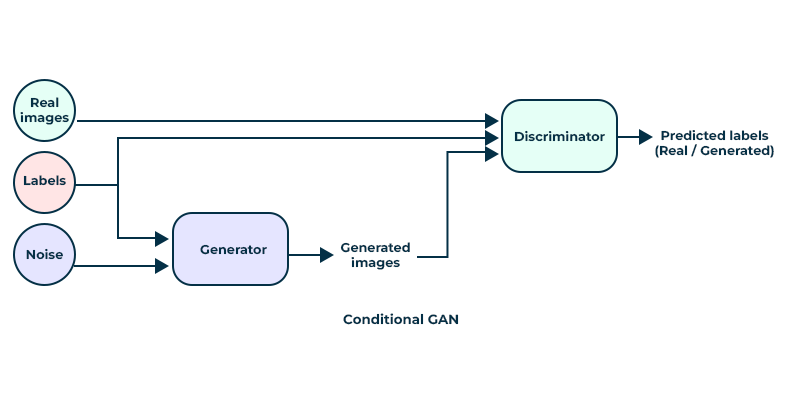

**CGAN on CIFAR-10 Dataset**

Overview

- Dataset: CIFAR-10 (50,000 training images, 10 classes).
- Generator: Takes random noise and a class label, outputs a 32x32x3 image of that class.
- Discriminator: Takes an image and a class label, decides if it’s real or fake for that class.
- Goal: Generate realistic CIFAR-10 images conditioned on class labels (e.g., "truck," "bird").

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
latent_dim = 100        # Noise vector size
num_classes = 10        # CIFAR-10 has 10 classes
image_channels = 3      # RGB images
hidden_dim = 64         # Base feature size
image_size = 32         # 32x32 images
batch_size = 64
num_epochs = 50
lr = 0.0002             # Learning rate
beta1 = 0.5             # Adam beta1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, latent_dim)  # Embed labels to match noise dim
        self.main = nn.Sequential(
            # Input: (latent_dim + label) x 1 x 1
            nn.ConvTranspose2d(latent_dim * 2, hidden_dim * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.ReLU(True),
            # 4x4
            nn.ConvTranspose2d(hidden_dim * 8, hidden_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.ReLU(True),
            # 8x8
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),
            # 16x16
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
            # 32x32
            nn.ConvTranspose2d(hidden_dim, image_channels, 4, 1, 0, bias=False),
            nn.Tanh()  # Output: 32x32x3
        )

    def forward(self, noise, labels):
        # Embed labels and concatenate with noise
        label_emb = self.label_emb(labels).view(labels.size(0), latent_dim, 1, 1)
        input = torch.cat([noise, label_emb], dim=1)  # Concat along channel dimension
        return self.main(input)

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, image_size * image_size)  # Embed labels to match flattened image
        self.main = nn.Sequential(
            # Input: 32x32x(3 + 1) after concatenating label channel
            nn.Conv2d(image_channels + 1, hidden_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 16x16
            nn.Conv2d(hidden_dim, hidden_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 8x8
            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 4x4
            nn.Conv2d(hidden_dim * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Output: 1 (real/fake probability)
        )

    def forward(self, images, labels):
        # Embed labels, reshape to 32x32, and concatenate as an extra channel
        label_emb = self.label_emb(labels).view(labels.size(0), 1, image_size, image_size)
        input = torch.cat([images, label_emb], dim=1)  # Concat along channel dimension
        return self.main(input)

# Initialize models and move to device
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Weight initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

generator.apply(weights_init)
discriminator.apply(weights_init)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
criterion = nn.BCELoss()

# Training Loop
fixed_noise = torch.randn(16, latent_dim, 1, 1, device=device)  # Fixed noise for visualization
fixed_labels = torch.tensor([i % num_classes for i in range(16)], dtype=torch.long, device=device)  # 0-9 labels
real_label = 1.0
fake_label = 0.0

for epoch in range(num_epochs):
    for i, (real_images, labels) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        labels = labels.to(device)

        # 1. Train Discriminator
        d_optimizer.zero_grad()
        label_tensor = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        output = discriminator(real_images, labels).view(-1)
        d_loss_real = criterion(output, label_tensor)
        d_loss_real.backward()

        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise, labels)
        label_tensor.fill_(fake_label)
        output = discriminator(fake_images.detach(), labels).view(-1)
        d_loss_fake = criterion(output, label_tensor)
        d_loss_fake.backward()

        d_loss = d_loss_real + d_loss_fake
        d_optimizer.step()

        # 2. Train Generator
        g_optimizer.zero_grad()
        label_tensor.fill_(real_label)
        output = discriminator(fake_images, labels).view(-1)
        g_loss = criterion(output, label_tensor)
        g_loss.backward()
        g_optimizer.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(train_loader)}] "
                  f"D Loss: {d_loss.item():.4f} G Loss: {g_loss.item():.4f}")

    # Save generated images every 5 epochs
    if epoch % 5 == 0:
        with torch.no_grad():
            fake_images = generator(fixed_noise, fixed_labels).detach().cpu()
        plt.figure(figsize=(4, 4))
        for j in range(16):
            plt.subplot(4, 4, j+1)
            plt.imshow(np.transpose((fake_images[j] + 1) / 2, (1, 2, 0)))  # Denormalize
            plt.title(f"Class {fixed_labels[j].item()}")
            plt.axis('off')
        plt.savefig(f"cgan_epoch_{epoch}.png")
        plt.close()

# Save final model
# torch.save(generator.state_dict(), "cgan_generator.pth")
# torch.save(discriminator.state_dict(), "cgan_discriminator.pth")

#### Deep Convolutional GAN (DCGAN)

Deep Convolutional GANs (DCGANs) are among the most popular and widely used types of GANs, particularly for image generation.



    Introduced by Alec Radford, Luke Metz, and Soumith Chintala in their 2015 paper
    "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks."

What Makes DCGAN Special?

- Fully connected layers are removed, allowing for better spatial understanding of images.
- Uses `Convolutional Neural Networks (CNNs)` instead of simple multi-layer perceptrons (MLPs).
- Max pooling layers are replaced with convolutional stride, making the model more efficient.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
latent_dim = 100        # Size of the noise vector
image_channels = 3      # RGB images
hidden_dim = 64         # Base feature size for convolutional layers
image_size = 32         # CIFAR-10 image size (32x32)
batch_size = 128        # Larger batch size for stability
num_epochs = 50         # Adjust based on compute power (50-200 recommended)
lr = 0.0002             # Learning rate (DCGAN standard)
beta1 = 0.5             # Adam beta1 for better gradient flow
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, hidden_dim * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.ReLU(True),
            # Output: 4x4x512
            nn.ConvTranspose2d(hidden_dim * 8, hidden_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.ReLU(True),
            # Output: 8x8x256
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),
            # Output: 16x16x128
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
            # Output: 32x32x64
            nn.ConvTranspose2d(hidden_dim, image_channels, 4, 1, 0, bias=False),
            nn.Tanh()  # Output range [-1, 1] to match normalized images
            # Output: 32x32x3
        )

    def forward(self, x):
        return self.main(x)

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: 32x32x3
            nn.Conv2d(image_channels, hidden_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 16x16x64
            nn.Conv2d(hidden_dim, hidden_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 8x8x128
            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 4x4x256
            nn.Conv2d(hidden_dim * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Output probability (0 = fake, 1 = real)
            # Output: 1x1x1
        )

    def forward(self, x):
        return self.main(x)

# Weight initialization (DCGAN guideline)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Initialize models and apply weight initialization
generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.apply(weights_init)
discriminator.apply(weights_init)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
criterion = nn.BCELoss()

# Fixed noise for consistent visualization
fixed_noise = torch.randn(16, latent_dim, 1, 1, device=device)

# Training Loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Labels for real and fake
        real_label = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
        fake_label = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

        # --- Train Discriminator ---
        d_optimizer.zero_grad()

        # Real images
        output = discriminator(real_images).view(-1)
        d_loss_real = criterion(output, real_label)
        d_loss_real.backward()

        # Fake images
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        output = discriminator(fake_images.detach()).view(-1)  # Detach to avoid G backprop
        d_loss_fake = criterion(output, fake_label)
        d_loss_fake.backward()

        d_loss = d_loss_real + d_loss_fake
        d_optimizer.step()

        # --- Train Generator ---
        g_optimizer.zero_grad()
        output = discriminator(fake_images).view(-1)  # Recompute for G backprop
        g_loss = criterion(output, real_label)  # G wants D to think fakes are real
        g_loss.backward()
        g_optimizer.step()

        # Print progress
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(train_loader)}] "
                  f"D Loss: {d_loss.item():.4f} G Loss: {g_loss.item():.4f}")

    # Visualize generated images every 5 epochs
    if epoch % 5 == 0 or epoch == num_epochs - 1:
        with torch.no_grad():
            fake_images = generator(fixed_noise).detach().cpu()
        plt.figure(figsize=(4, 4))
        for j in range(16):
            plt.subplot(4, 4, j + 1)
            # Denormalize: [-1, 1] -> [0, 1]
            img = np.transpose((fake_images[j] + 1) / 2, (1, 2, 0))
            plt.imshow(img.clip(0, 1))  # Clip to avoid out-of-range values
            plt.axis('off')
        plt.savefig(f"dcgan_cifar10_epoch_{epoch}.png")
        plt.close()

# Save final models
# torch.save(generator.state_dict(), "dcgan_generator.pth")
# torch.save(discriminator.state_dict(), "dcgan_discriminator.pth")

print("Training complete! Check saved images and model files.")

#### Laplacian Pyramid GAN (LAPGAN)

Laplacian Pyramid GAN (LAPGAN) is designed to generate ultra-high-quality images by leveraging a `multi-resolution approach`.

Working of LAPGAN:

- Uses multiple generator-discriminator pairs at `different levels of the Laplacian pyramid`.
- Images are first downsampled at each layer of the pyramid and upscaled again using Conditional GANs (CGANs).
- This process allows the image to gradually refine details, reducing noise and improving clarity.


    Introduced by Emily Denton et al. in their 2015 paper
    "Deep Generative Image Models using a Laplacian Pyramid of Adversarial Networks."
    LAPGAN combines the power of GANs with the Laplacian pyramid—a classical image processing technique.

Before we get to the GAN part, understand the Laplacian Pyramid (from classical image processing - DIP tutorial).

**Architecture**

LAPGAN consists of a stack of GANs, one for each level of the pyramid:

Coarsest Level (e.g., 8x8):
- A simple GAN generates a low-resolution base image (GN) from noise.

Subsequent Levels (e.g., 16x16, 32x32, 64x64):
- Each GAN takes the upsampled output from the previous level, adds generated "detail" (like a residual), and refines it to the next resolution.

Each GAN has:

- Generator (G): Produces either the coarse image (at the top) or detail residuals (at higher levels).
- Discriminator (D): Judges whether the image (or detail) at that resolution is real or fake.

#### StyleGAN

StyleGAN, an advanced Generative Adversarial Network (GAN) developed by
  
    Tero Karras and his team at NVIDIA, first introduced in 2018 and later refined in StyleGAN2 (2019) and StyleGAN3 (2021).

StyleGAN is a GAN designed to generate high-resolution, highly detailed images with fine-grained control over the output’s features (e.g., facial expressions, hair color, age).

**Key Innovations in StyleGAN**

**Style-Based Generator:**
- Instead of feeding noise directly into the generator, StyleGAN maps noise into a latent space (called w) via a mapping network, then uses this to control "styles" at multiple layers.
- This allows precise control over features at different scales (e.g., eyes vs. wrinkles).

**Progressive Growing:**
- Inherited from ProGAN, StyleGAN trains by starting with low-resolution images (e.g., 4x4) and progressively adds layers to reach high resolutions (e.g., 1024x1024).
- This stabilizes training and improves quality.

**Adaptive Instance Normalization (AdaIN):**
- At each layer, the style vector adjusts the feature maps’ scale and bias, blending content and style dynamically.

**Noise Injection:**
- Random noise is added at each layer to introduce fine, stochastic details (e.g., hair strands, freckles).

**Improved Variants:**
- StyleGAN2: Fixes artifacts (e.g., "blob-like" distortions) and improves consistency.
- StyleGAN3: Addresses aliasing issues for smoother animations and better temporal coherence.

In [ ]:
# Mapping Network
class MappingNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(*[nn.Linear(512, 512) for _ in range(8)])
    def forward(self, z):
        return self.fc(z)

# Synthesis Block (simplified)
class SynthesisBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.adaIN = lambda x, w: # Apply style via AdaIN
        self.noise = lambda x: x + torch.randn_like(x) * 0.1
    def forward(self, x, w):
        x = self.conv(x)
        x = self.adaIN(x, w)
        x = self.noise(x)
        return x

simplified StyleGAN-inspired model in PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set random seed and device
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 64        # Noise vector size
style_dim = 64         # Style vector size (w)
image_channels = 1     # Grayscale (MNIST)
hidden_dim = 128       # Base feature size
batch_size = 64
num_epochs = 20
lr = 0.0002
beta1 = 0.5

# Data loading (MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Adaptive Instance Normalization (AdaIN)
def adaIN(x, style):
    # x: [batch, channels, h, w], style: [batch, style_dim]
    mean = x.mean(dim=(2, 3), keepdim=True)
    std = x.std(dim=(2, 3), keepdim=True) + 1e-6
    style_mean = style[:, :x.size(1)].unsqueeze(2).unsqueeze(3)  # Match channels
    style_std = style[:, x.size(1):2*x.size(1)].unsqueeze(2).unsqueeze(3)
    return style_std * (x - mean) / std + style_mean

# Mapping Network
class MappingNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, style_dim * 2)  # Output 2x style_dim for mean and std
        )

    def forward(self, z):
        return self.fc(z)

# Generator (Synthesis Network)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.initial = nn.Parameter(torch.randn(1, hidden_dim, 4, 4))  # Learned constant
        self.layers = nn.ModuleList([
            # 4x4 -> 7x7
            nn.Sequential(
                nn.ConvTranspose2d(hidden_dim, hidden_dim, 4, 2, 1),
                nn.LeakyReLU(0.2)
            ),
            # 7x7 -> 14x14
            nn.Sequential(
                nn.ConvTranspose2d(hidden_dim, hidden_dim // 2, 4, 2, 1),
                nn.LeakyReLU(0.2)
            ),
            # 14x14 -> 28x28
            nn.Sequential(
                nn.ConvTranspose2d(hidden_dim // 2, image_channels, 4, 2, 1),
                nn.Tanh()  # Output [-1, 1]
            )
        ])

    def forward(self, z, mapping_net):
        # Get style vector
        style = mapping_net(z)  # [batch, style_dim * 2]

        # Initial tensor
        x = self.initial.repeat(z.size(0), 1, 1, 1)  # [batch, hidden_dim, 4, 4]

        # Apply layers with AdaIN and noise
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:  # Skip AdaIN on final layer
                x = adaIN(x, style)
                x = x + torch.randn_like(x) * 0.1  # Noise injection

        return x

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(image_channels, hidden_dim // 2, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(hidden_dim // 2, hidden_dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(hidden_dim, 1, 4, 2, 0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1)

# Initialize models
mapping_net = MappingNetwork().to(device)
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
g_optimizer = optim.Adam(list(generator.parameters()) + list(mapping_net.parameters()), lr=lr, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
criterion = nn.BCELoss()

# Training Loop
fixed_noise = torch.randn(16, latent_dim, device=device)  # For visualization
real_label = 1.0
fake_label = 0.0

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # 1. Train Discriminator
        d_optimizer.zero_grad()
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        output = discriminator(real_images)
        d_loss_real = criterion(output, label)
        d_loss_real.backward()

        noise = torch.randn(batch_size, latent_dim, device=device)
        fake_images = generator(noise, mapping_net)
        label.fill_(fake_label)
        output = discriminator(fake_images.detach())
        d_loss_fake = criterion(output, label)
        d_loss_fake.backward()

        d_loss = d_loss_real + d_loss_fake
        d_optimizer.step()

        # 2. Train Generator
        g_optimizer.zero_grad()
        label.fill_(real_label)
        output = discriminator(fake_images)
        g_loss = criterion(output, label)
        g_loss.backward()
        g_optimizer.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(train_loader)}] "
                  f"D Loss: {d_loss.item():.4f} G Loss: {g_loss.item():.4f}")

    # Save generated images
    if epoch % 5 == 0:
        with torch.no_grad():
            fake_images = generator(fixed_noise, mapping_net).detach().cpu()
        plt.figure(figsize=(4, 4))
        for j in range(16):
            plt.subplot(4, 4, j+1)
            plt.imshow(fake_images[j, 0], cmap='gray', vmin=-1, vmax=1)
            plt.axis('off')
        plt.savefig(f"stylegan_epoch_{epoch}.png")
        plt.close()

# Save models
# torch.save(generator.state_dict(), "stylegan_generator.pth")
# torch.save(discriminator.state_dict(), "stylegan_discriminator.pth")

### Types of Super-Resolution GANs

#### Super Resolution GAN (SRGAN)

    Introduced by Christian Ledig and colleagues in 2017,
    SRGAN is a game-changer for tasks like upscaling blurry photos or improving video quality.

**How Does SRGAN Differ from Other GANs?**

- Vanilla GAN: Generates images from noise, no input image.
- CGAN: Generates conditioned outputs (e.g., "cat"), not tied to resolution.
- StyleGAN: Creates high-res images from scratch with style control.
- SRGAN: Takes an LR image as input and upsamples it to HR, focusing on enhancing existing content.

**Core Components**

Generator (G):
- Input: A low-resolution image (e.g., 64x64x3).
- Output: A high-resolution image (e.g., 256x256x3).
- Role: Upsamples the LR image and adds realistic details.

Discriminator (D):
- Input: Either a real HR image or a generated HR image from G.
- Output: Probability (0 to 1) that the input is a real HR image.
- Role: Pushes G to produce HR images indistinguishable from real ones.

Loss Functions:
- SRGAN uses a combination of losses to balance content accuracy and perceptual quality (more on this below).

Architecture

**1. Generator**

Structure: A deep convolutional neural network with residual blocks.

- Initial Convolution: Extracts features from the LR input.
- Residual Blocks: Multiple blocks (e.g., 16) with skip connections to refine features without losing information.
- Each block: Conv → BatchNorm → PReLU → Conv → BatchNorm.
- Upsampling: Sub-pixel convolution (PixelShuffle) to increase resolution (e.g., 2x or 4x scaling).
- Final Convolution: Outputs the HR image (e.g., 3 channels for RGB).

Example:

    Input: 64x64 → 16 residual blocks → 2x upscale (128x128) → 2x upscale (256x256).

**2. Discriminator**

Structure: A convolutional network inspired by VGG architecture.
- Layers: Multiple Conv → LeakyReLU → BatchNorm, progressively downsampling.
- Final layers: Dense → Sigmoid to output a real/fake probability.
- Purpose: Judges whether the HR image looks authentic.

**3. Preprocessing**

- Input: LR images are typically downsampled versions of HR images (e.g., bicubic downsampling by 4x).
- Dataset: Paired LR-HR images (e.g., DIV2K, Set5).

Loss Functions

SRGAN’s magic lies in its hybrid loss:

Content Loss:
- Pixel-wise MSE: Measures raw pixel differences between generated and real HR images (used in pretraining).
- Perceptual Loss: Uses features from a pretrained VGG19 network (e.g., layer 5-4) to compare high-level features, not just pixels.
- Why? Pixel MSE can make images blurry; VGG loss preserves textures and edges.

Adversarial Loss:
- Binary cross-entropy based on D’s output.
- Encourages G to produce images that D can’t distinguish from real HR images.

Total Generator Loss: LG = L_perceptual + λL_adv
- λ (e.g., 0.001) balances perceptual and adversarial terms.

Outcome

- G learns to upscale LR images, adding details (e.g., sharp edges, textures) that align with HR realism, guided by D and VGG.

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import vgg19

# Generator (simplified)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 9, padding=4), nn.PReLU(),
            *[nn.Sequential(nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.PReLU()) for _ in range(5)],  # 5 residual blocks
            nn.Conv2d(64, 256, 3, padding=1), nn.PixelShuffle(2), nn.PReLU(),  # 2x upscale
            nn.Conv2d(64, 256, 3, padding=1), nn.PixelShuffle(2), nn.PReLU(),  # 4x upscale
            nn.Conv2d(64, 3, 9, padding=4), nn.Tanh()
        )
    def forward(self, x):
        return self.main(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding=1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Flatten(), nn.Linear(256*64*64, 1024), nn.LeakyReLU(0.2), nn.Linear(1024, 1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.main(x)

# Perceptual Loss (VGG)
vgg = vgg19(pretrained=True).features[:16].eval()  # Up to layer 5-4

Let’s implement a full Super Resolution GAN (SRGAN) in PyTorch to upscale low-resolution CIFAR-10 images (e.g., from 8x8 to 32x32, a 4x upscaling factor).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import vgg19
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
lr_channels = 3         # RGB input
hr_channels = 3         # RGB output
scaling_factor = 4      # 8x8 -> 32x32
feature_dim = 64        # Base feature size
num_residual_blocks = 5 # Simplified from 16 for faster training
batch_size = 16         # Small batch for memory
num_epochs = 20         # Increase for better results (e.g., 200)
lr = 0.0001             # Learning rate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading and preprocessing
transform_hr = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [-1, 1]
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_hr)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create LR images on-the-fly
transform_lr = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(8, interpolation=transforms.InterpolationMode.BICUBIC),  # Downsample to 8x8
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Initial convolution
        self.initial = nn.Sequential(
            nn.Conv2d(lr_channels, feature_dim, 9, padding=4, padding_mode='reflect'),
            nn.PReLU()
        )
        # Residual blocks
        self.res_blocks = nn.Sequential(*[
            nn.Sequential(
                nn.Conv2d(feature_dim, feature_dim, 3, padding=1, padding_mode='reflect'),
                nn.BatchNorm2d(feature_dim),
                nn.PReLU(),
                nn.Conv2d(feature_dim, feature_dim, 3, padding=1, padding_mode='reflect'),
                nn.BatchNorm2d(feature_dim)
            ) for _ in range(num_residual_blocks)
        ])
        # Upsampling (4x: 8x8 -> 16x16 -> 32x32)
        self.upsample = nn.Sequential(
            nn.Conv2d(feature_dim, feature_dim * 4, 3, padding=1, padding_mode='reflect'),
            nn.PixelShuffle(2),  # 8x8 -> 16x16
            nn.PReLU(),
            nn.Conv2d(feature_dim, feature_dim * 4, 3, padding=1, padding_mode='reflect'),
            nn.PixelShuffle(2),  # 16x16 -> 32x32
            nn.PReLU()
        )
        # Output layer
        self.output = nn.Conv2d(feature_dim, hr_channels, 9, padding=4, padding_mode='reflect')

    def forward(self, x):
        x = self.initial(x)
        residual = x
        x = self.res_blocks(x)
        x = x + residual  # Skip connection
        x = self.upsample(x)
        return torch.tanh(self.output(x))  # [-1, 1]

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(hr_channels, feature_dim, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_dim, feature_dim, 3, stride=2, padding=1),
            nn.BatchNorm2d(feature_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_dim, feature_dim * 2, 3, stride=1, padding=1),
            nn.BatchNorm2d(feature_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_dim * 2, feature_dim * 2, 3, stride=2, padding=1),
            nn.BatchNorm2d(feature_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_dim * 2, feature_dim * 4, 3, stride=1, padding=1),
            nn.BatchNorm2d(feature_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_dim * 4, feature_dim * 4, 3, stride=2, padding=1),
            nn.BatchNorm2d(feature_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(feature_dim * 4 * 4 * 4, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

# VGG for perceptual loss
vgg = vgg19(pretrained=True).features[:16].eval().to(device)  # Up to layer 5-4
for param in vgg.parameters():
    param.requires_grad = False

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.9, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.9, 0.999))

# Loss functions
criterion_bce = nn.BCELoss()
criterion_mse = nn.MSELoss()

# Training Loop
for epoch in range(num_epochs):
    for i, (hr_images, _) in enumerate(train_loader):
        hr_images = hr_images.to(device)
        batch_size = hr_images.size(0)

        # Create LR images
        lr_images = torch.stack([transform_lr(img.cpu()) for img in hr_images]).to(device)

        # 1. Train Discriminator
        d_optimizer.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Real HR images
        real_output = discriminator(hr_images)
        d_loss_real = criterion_bce(real_output, real_labels)

        # Fake HR images from Generator
        fake_hr_images = generator(lr_images)
        fake_output = discriminator(fake_hr_images.detach())
        d_loss_fake = criterion_bce(fake_output, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # 2. Train Generator
        g_optimizer.zero_grad()
        fake_output = discriminator(fake_hr_images)
        adversarial_loss = criterion_bce(fake_output, real_labels)  # Fool D

        # Perceptual loss (VGG features)
        real_features = vgg(hr_images)
        fake_features = vgg(fake_hr_images)
        perceptual_loss = criterion_mse(fake_features, real_features)

        g_loss = 0.006 * perceptual_loss + 0.001 * adversarial_loss  # Weighting as per SRGAN paper
        g_loss.backward()
        g_optimizer.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(train_loader)}] "
                  f"D Loss: {d_loss.item():.4f} G Loss: {g_loss.item():.4f}")

    # Visualize results every 5 epochs
    if epoch % 5 == 0:
        with torch.no_grad():
            fake_hr_images = generator(lr_images[:4]).cpu()
            lr_images = lr_images.cpu()
            hr_images = hr_images.cpu()
            plt.figure(figsize=(12, 4))
            for j in range(4):
                plt.subplot(3, 4, j+1)
                plt.imshow(np.transpose((lr_images[j] + 1) / 2, (1, 2, 0)))
                plt.title("LR")
                plt.axis('off')
                plt.subplot(3, 4, j+5)
                plt.imshow(np.transpose((fake_hr_images[j] + 1) / 2, (1, 2, 0)))
                plt.title("SR")
                plt.axis('off')
                plt.subplot(3, 4, j+9)
                plt.imshow(np.transpose((hr_images[j] + 1) / 2, (1, 2, 0)))
                plt.title("HR")
                plt.axis('off')
            plt.savefig(f"epoch_{epoch}.png")
            plt.close()

# Save models
# torch.save(generator.state_dict(), "srgan_generator.pth")
# torch.save(discriminator.state_dict(), "srgan_discriminator.pth")

### Types of Deepfake Technology GANs

FaceSwap, DeepFaceLab

### Image-to-Image Translation - GANs

#### Pix2Pix

Pix2Pix is a conditional GAN (CGAN) tailored for translating images from one domain to another, given paired examples (e.g., an edge map → a photo).

    Introduced by Phillip Isola and colleagues in 2016,

Pix2Pix excels at tasks like turning sketches into photos, black-and-white images into color, or satellite images into maps.

It learns a direct mapping from input images (e.g., a sketch) to output images (e.g., a realistic rendering) by combining adversarial training with a reconstruction loss.

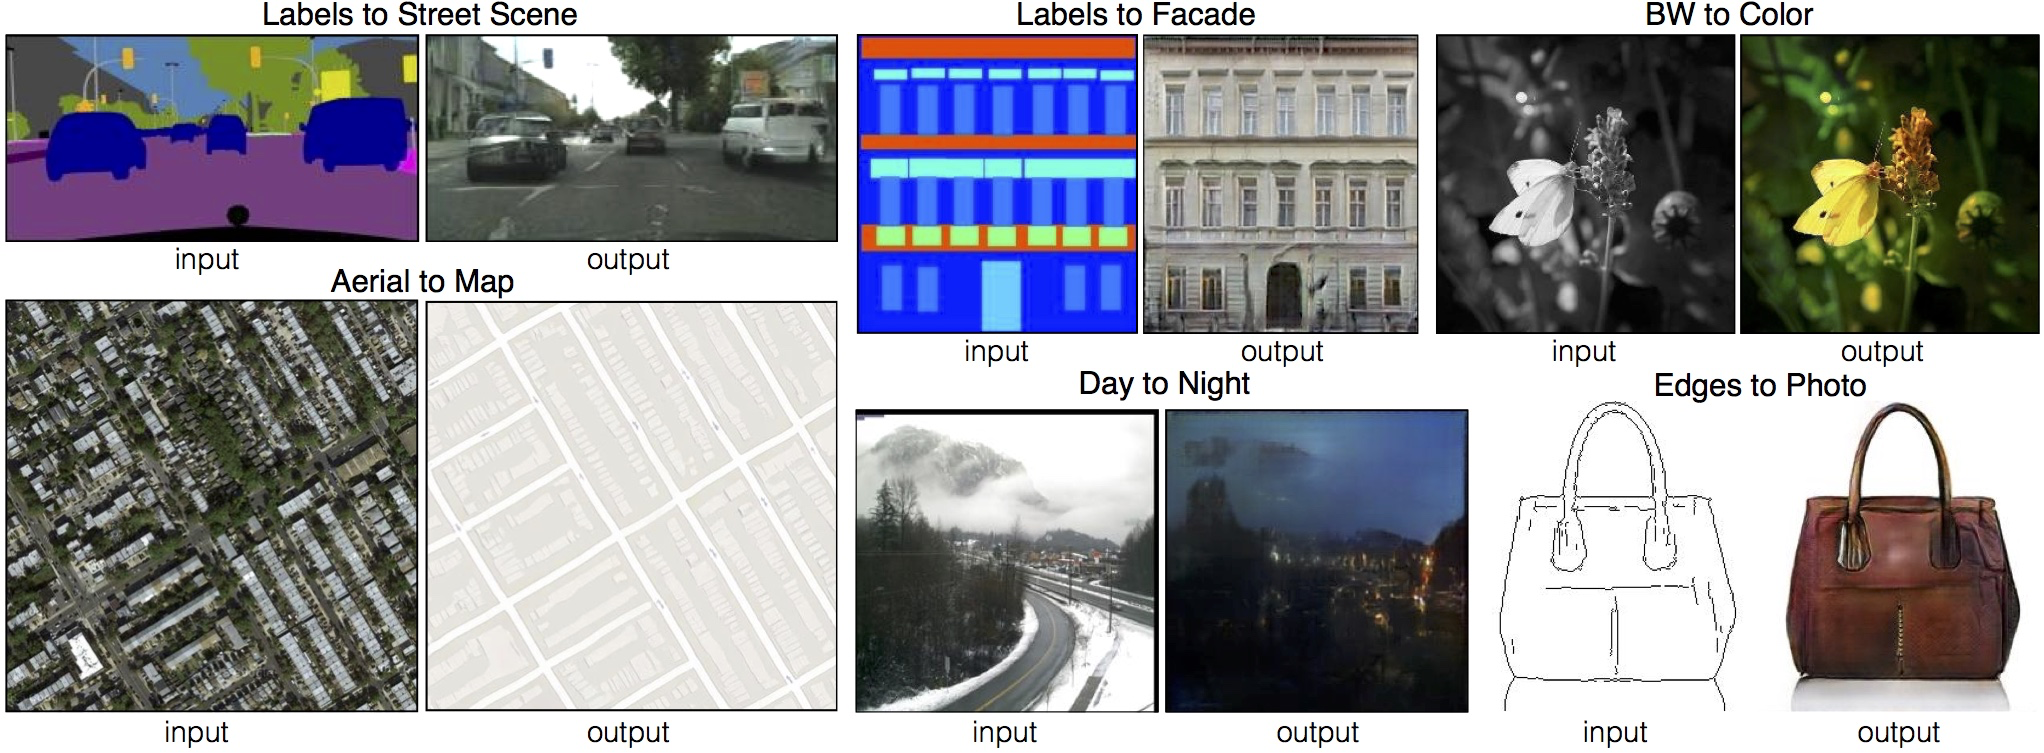

**How Does Pix2Pix Differ from Other GANs?**

- Vanilla GAN: Generates from noise, no input image.
- StyleGAN: Creates high-res images with style control, not translation.
- CycleGAN: Translates unpaired domains (e.g., horse → zebra).
- Pix2Pix: Translates paired images (e.g., sketch → photo), supervised.

**Architecture**

**1. Generator**

Structure: A U-Net architecture.
- Encoder: Downsampling conv layers (e.g., Conv → BatchNorm → LeakyReLU) to extract features.
- Bottleneck: Dense feature representation.
- Decoder: Upsampling with transposed conv layers (e.g., ConvTranspose → BatchNorm → ReLU) + skip connections from encoder layers.
- Output: Same size as input (e.g., 256x256x3).
- Why U-Net?: Skip connections preserve spatial details from x (e.g., edges), ensuring G(x) aligns with the input structure.

**2. Discriminator**

Structure: PatchGAN architecture.
- Multiple conv layers (e.g., 4x4 Conv → BatchNorm → LeakyReLU).
- Outputs a feature map (e.g., 30x30x1), not a single scalar.
- Each patch (e.g., 70x70 receptive field) judges local realness.
- Why PatchGAN?: Focuses on texture/style at multiple scales, not global coherence.

**3. Loss Functions**

Adversarial Loss:

    L_GAN(G,D) = E[logD(x,y)]+E[log(1−D(x,G(x)))].
    D maximizes this;
    G minimizes it to fool D.

L1 Loss (Reconstruction Loss):

    L_L1(G) = E[∣∣y−G(x)∣∣].
    Ensures G(x) is close to the ground truth y.
Total Generator Loss:

    L_G = L_GAN(G,D)+λL_L1(G).
    λ (e.g., 100) heavily weights L1 to enforce content accuracy.

In [ ]:
import torch
import torch.nn as nn

# Generator (U-Net)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.down1 = nn.Sequential(nn.Conv2d(3, 64, 4, stride=2, padding=1), nn.LeakyReLU(0.2))
        self.down2 = nn.Sequential(nn.Conv2d(64, 128, 4, stride=2, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2))
        # Decoder with skip connections
        self.up1 = nn.Sequential(nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU())
        self.up2 = nn.Sequential(nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1), nn.Tanh())

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        u1 = self.up1(d2)
        u2 = self.up2(torch.cat([u1, d1], dim=1))  # Skip connection
        return u2

# Discriminator (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(6, 64, 4, stride=2, padding=1), nn.LeakyReLU(0.2),  # 3 (input) + 3 (output)
            nn.Conv2d(64, 128, 4, stride=2, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 1, 4, padding=1)  # Patch output
        )
    def forward(self, x, y):
        return self.main(torch.cat([x, y], dim=1))  # Concat input and output

# Loss
g = Generator()
d = Discriminator()
adv_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

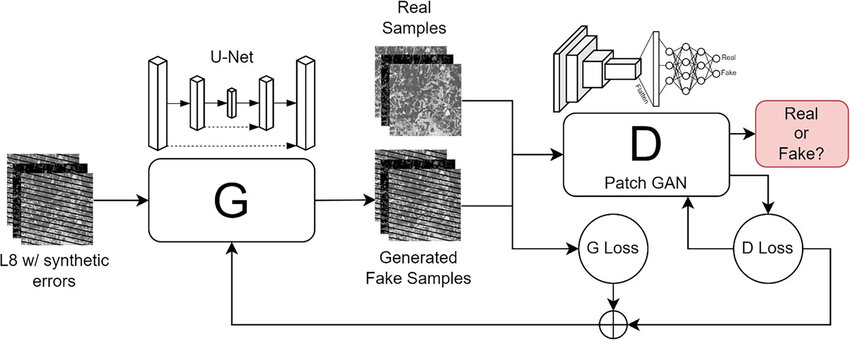

**How Does Pix2Pix Work?**

**1. Training Process**

Step 1: Train Discriminator:

- Real pairs: (x,y) (e.g., sketch + photo, label 1).
- Fake pairs: (x,G(x)) (e.g., sketch + generated photo, label 0).
- Loss: BCE to improve D’s classification.

Step 2: Train Generator:
- Generate G(x), pass to D with x, aim for label 1.
- Add L1 loss to match y.
- Loss: Combined adversarial + L1.

Iterate: Alternate D and G updates.

**2. Conditioning**

- D sees x alongside y or G(x), ensuring the output matches the input contextually (e.g., edges align with the sketch).

**3. Outcome**
- G learns a precise mapping (e.g., sketch → photo) with realistic textures, guided by paired data.

---
Pix2Pix implementation - sketch → photo

let's adapt the implementation to work with CIFAR-10 (32x32x3 images), `generating edge maps` as sketches from the original images and training Pix2Pix to reconstruct the photos.

For a real-world sketch-to-photo task, you’d typically use a dataset like the `Facade` or `Edges2Cats` datasets, but this will be a great learning example!

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
image_size = 32         # CIFAR-10 size
channels = 3            # RGB
sketch_channels = 1     # Grayscale edges
batch_size = 16
num_epochs = 50         # Increase for better results
lr = 0.0002             # Learning rate
beta1 = 0.5             # Adam beta1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset for Paired Sketch-Photo
class SketchPhotoDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = torchvision.datasets.CIFAR10(root=root, train=True, download=True, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        photo, _ = self.dataset[idx]  # Photo: 32x32x3 tensor
        photo_np = np.transpose(photo.numpy(), (1, 2, 0))  # HWC for OpenCV
        photo_np = (photo_np * 0.5 + 0.5) * 255  # Denormalize to [0, 255]
        photo_np = photo_np.astype(np.uint8)

        # Generate sketch (edges) using Canny
        sketch = cv2.Canny(photo_np, 100, 200)  # Edge detection
        sketch = sketch / 255.0  # Normalize to [0, 1]
        sketch = torch.tensor(sketch, dtype=torch.float32).unsqueeze(0)  # 1x32x32
        sketch = sketch * 2 - 1  # Normalize to [-1, 1]

        return sketch, photo  # Sketch, Photo pair

# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [-1, 1]
])
dataset = SketchPhotoDataset(root='./data', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator (U-Net)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Encoder
        self.down1 = nn.Sequential(nn.Conv2d(sketch_channels, 64, 4, stride=2, padding=1), nn.LeakyReLU(0.2, True))
        self.down2 = nn.Sequential(nn.Conv2d(64, 128, 4, stride=2, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, True))
        self.down3 = nn.Sequential(nn.Conv2d(128, 256, 4, stride=2, padding=1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, True))
        # Decoder
        self.up1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU(True))
        self.up2 = nn.Sequential(nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(True))
        self.up3 = nn.Sequential(nn.ConvTranspose2d(128, channels, 4, stride=2, padding=1), nn.Tanh())

    def forward(self, x):
        d1 = self.down1(x)  # 16x16
        d2 = self.down2(d1)  # 8x8
        d3 = self.down3(d2)  # 4x4
        u1 = self.up1(d3)  # 8x8
        u2 = self.up2(torch.cat([u1, d2], dim=1))  # 16x16, skip connection
        u3 = self.up3(torch.cat([u2, d1], dim=1))  # 32x32, skip connection
        return u3

# Discriminator (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(sketch_channels + channels, 64, 4, stride=2, padding=1), nn.LeakyReLU(0.2, True),  # 1 + 3 channels
            nn.Conv2d(64, 128, 4, stride=2, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, True),
            nn.Conv2d(256, 1, 4, padding=1)  # Patch output (e.g., 4x4)
        )

    def forward(self, sketch, photo):
        return self.main(torch.cat([sketch, photo], dim=1))  # Concat sketch and photo

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss functions
adv_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()
lambda_l1 = 100  # Weight for L1 loss

# Training Loop
for epoch in range(num_epochs):
    for i, (sketches, photos) in enumerate(dataloader):
        sketches, photos = sketches.to(device), photos.to(device)
        batch_size = sketches.size(0)

        # 1. Train Discriminator
        d_optimizer.zero_grad()
        real_labels = torch.ones(batch_size, 1, 4, 4).to(device)  # PatchGAN output size
        fake_labels = torch.zeros(batch_size, 1, 4, 4).to(device)

        # Real pairs
        real_output = discriminator(sketches, photos)
        d_loss_real = adv_loss(real_output, real_labels)

        # Fake pairs
        fake_photos = generator(sketches)
        fake_output = discriminator(sketches, fake_photos.detach())
        d_loss_fake = adv_loss(fake_output, fake_labels)

        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        d_optimizer.step()

        # 2. Train Generator
        g_optimizer.zero_grad()
        fake_output = discriminator(sketches, fake_photos)
        g_adv_loss = adv_loss(fake_output, real_labels)  # Fool D
        g_l1_loss = l1_loss(fake_photos, photos)  # Match ground truth
        g_loss = g_adv_loss + lambda_l1 * g_l1_loss
        g_loss.backward()
        g_optimizer.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] "
                  f"D Loss: {d_loss.item():.4f} G Loss: {g_loss.item():.4f}")

    # Visualize results every 5 epochs
    if epoch % 5 == 0:
        with torch.no_grad():
            fake_photos = generator(sketches[:4]).cpu()
            sketches = sketches.cpu()
            photos = photos.cpu()
            plt.figure(figsize=(12, 4))
            for j in range(4):
                plt.subplot(3, 4, j+1)
                plt.imshow(sketches[j][0], cmap='gray')  # Sketch (grayscale)
                plt.title("Sketch")
                plt.axis('off')
                plt.subplot(3, 4, j+5)
                plt.imshow(np.transpose((fake_photos[j] + 1) / 2, (1, 2, 0)))  # Denormalize
                plt.title("Generated")
                plt.axis('off')
                plt.subplot(3, 4, j+9)
                plt.imshow(np.transpose((photos[j] + 1) / 2, (1, 2, 0)))
                plt.title("Photo")
                plt.axis('off')
            plt.savefig(f"epoch_{epoch}.png")
            plt.close()

# Save models
# torch.save(generator.state_dict(), "pix2pix_generator.pth")
# torch.save(discriminator.state_dict(), "pix2pix_discriminator.pth")

#### CycleGAN

CycleGAN, a fascinating Generative Adversarial Network (GAN) designed for image-to-image translation without paired data.

    Introduced by Jun-Yan Zhu and colleagues in 2017,

CycleGAN enables tasks like turning horses into zebras, summer landscapes into winter scenes, or photos into Monet paintings—all without needing aligned "before and after" examples.

**How Does CycleGAN Differ from Other GANs?**

- Vanilla GAN: Generates from noise, no input image.
- SRGAN: Enhances resolution of an input image.
- Pix2Pix: Translates paired images (e.g., edge → photo).
- CycleGAN: Translates unpaired images across domains (e.g., horse → zebra), no supervision needed.

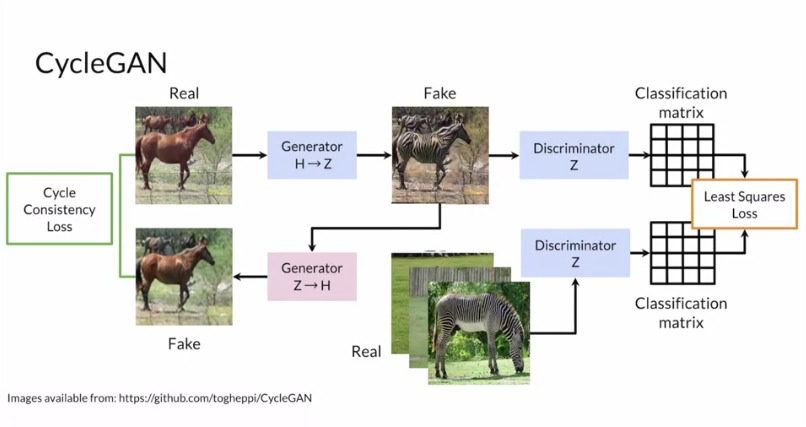

Core Components

Two Generators:
- G:H→Z: Maps domain H to domain Z (e.g., horse → zebra).
- F:Z→H: Maps domain Z back to H (e.g., zebra → horse).
- Role: Each generates images in the target domain.

Two Discriminators:
- DH : Distinguishes real H images from fake H images (from F).
- DZ : Distinguishes real Y images from fake Z images (from G).
- Role: Push generators to produce realistic outputs.

Cycle-Consistency:
- Ensures F(G(h))≈h and G(F(z))≈z.
- Prevents generators from producing arbitrary outputs.

In [ ]:
import torch
import torch.nn as nn

# Generator (simplified)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 7, padding=3), nn.InstanceNorm2d(64), nn.ReLU(True),  # Encoder
            *[nn.Sequential(nn.Conv2d(64, 64, 3, padding=1), nn.InstanceNorm2d(64), nn.ReLU(True)) for _ in range(6)],  # 6 Res blocks
            nn.ConvTranspose2d(64, 3, 7, padding=3), nn.Tanh()  # Decoder
        )
    def forward(self, x):
        return self.main(x)

# Discriminator (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1), nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), nn.InstanceNorm2d(128), nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 1, 4, padding=1)  # Patch output
        )
    def forward(self, x):
        return self.main(x)

# Loss
g_x2y, g_y2x = Generator(), Generator()
d_x, d_y = Discriminator(), Discriminator()
adv_loss = nn.BCEWithLogitsLoss()
cyc_loss = nn.L1Loss()

CycleGAN implementation (e.g., for CIFAR-10 cars → planes)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
image_channels = 3      # RGB
feature_dim = 64        # Base feature size
num_residual_blocks = 6 # Simplified for CIFAR-10
batch_size = 16
num_epochs = 50         # Increase for better results (e.g., 200)
lr = 0.0002             # Learning rate
lambda_cycle = 10.0     # Cycle loss weight
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [-1, 1]
])

# Load CIFAR-10
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split into cars (class 1) and planes (class 0)
car_indices = [i for i, (_, label) in enumerate(train_dataset) if label == 1]
plane_indices = [i for i, (_, label) in enumerate(train_dataset) if label == 0]
cars_dataset = Subset(train_dataset, car_indices[:5000])  # Limit for speed
planes_dataset = Subset(train_dataset, plane_indices[:5000])
cars_loader = DataLoader(cars_dataset, batch_size=batch_size, shuffle=True)
planes_loader = DataLoader(planes_dataset, batch_size=batch_size, shuffle=True)

# Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, feature_dim, 7, padding=3, padding_mode='reflect'),
            nn.InstanceNorm2d(feature_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_dim, feature_dim * 2, 4, stride=2, padding=1),
            nn.InstanceNorm2d(feature_dim * 2),
            nn.ReLU(inplace=True)
        )
        # Residual blocks
        self.res_blocks = nn.Sequential(*[
            nn.Sequential(
                nn.Conv2d(feature_dim * 2, feature_dim * 2, 3, padding=1, padding_mode='reflect'),
                nn.InstanceNorm2d(feature_dim * 2),
                nn.ReLU(inplace=True),
                nn.Conv2d(feature_dim * 2, feature_dim * 2, 3, padding=1, padding_mode='reflect'),
                nn.InstanceNorm2d(feature_dim * 2)
            ) for _ in range(num_residual_blocks)
        ])
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(feature_dim * 2, feature_dim, 4, stride=2, padding=1),
            nn.InstanceNorm2d(feature_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_dim, image_channels, 7, padding=3, padding_mode='reflect'),
            nn.Tanh()  # [-1, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        residual = x
        x = self.res_blocks(x)
        x = x + residual  # Skip connection
        return self.decoder(x)

# Discriminator Network (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(image_channels, feature_dim, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_dim, feature_dim * 2, 4, stride=2, padding=1),
            nn.InstanceNorm2d(feature_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_dim * 2, feature_dim * 4, 4, stride=1, padding=1),
            nn.InstanceNorm2d(feature_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_dim * 4, 1, 4, padding=1)  # Patch output (no sigmoid for LS-GAN)
        )

    def forward(self, x):
        return self.main(x)

# Initialize models
G_XtoY = Generator().to(device)  # Cars -> Planes
G_YtoX = Generator().to(device)  # Planes -> Cars
D_X = Discriminator().to(device) # Cars
D_Y = Discriminator().to(device) # Planes

# Optimizers
g_optimizer = optim.Adam(list(G_XtoY.parameters()) + list(G_YtoX.parameters()), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(list(D_X.parameters()) + list(D_Y.parameters()), lr=lr, betas=(0.5, 0.999))

# Loss functions (using Least Squares GAN for stability)
adv_loss_fn = nn.MSELoss()  # LS-GAN: real=1, fake=0
cycle_loss_fn = nn.L1Loss()

# Training Loop
cars_iter = iter(cars_loader)
planes_iter = iter(planes_loader)

for epoch in range(num_epochs):
    for i in range(min(len(cars_loader), len(planes_loader))):
        try:
            real_X = next(cars_iter)[0].to(device)  # Cars
        except StopIteration:
            cars_iter = iter(cars_loader)
            real_X = next(cars_iter)[0].to(device)
        try:
            real_Y = next(planes_iter)[0].to(device)  # Planes
        except StopIteration:
            planes_iter = iter(planes_loader)
            real_Y = next(planes_iter)[0].to(device)

        batch_size = real_X.size(0)

        # 1. Train Discriminators
        d_optimizer.zero_grad()

        # D_X: Real cars vs. fake cars (from G_YtoX)
        real_X_output = D_X(real_X)
        fake_X = G_YtoX(real_Y)
        fake_X_output = D_X(fake_X.detach())
        d_X_loss = adv_loss_fn(real_X_output, torch.ones_like(real_X_output)) + \
                   adv_loss_fn(fake_X_output, torch.zeros_like(fake_X_output))

        # D_Y: Real planes vs. fake planes (from G_XtoY)
        real_Y_output = D_Y(real_Y)
        fake_Y = G_XtoY(real_X)
        fake_Y_output = D_Y(fake_Y.detach())
        d_Y_loss = adv_loss_fn(real_Y_output, torch.ones_like(real_Y_output)) + \
                   adv_loss_fn(fake_Y_output, torch.zeros_like(fake_Y_output))

        d_loss = (d_X_loss + d_Y_loss) * 0.5
        d_loss.backward()
        d_optimizer.step()

        # 2. Train Generators
        g_optimizer.zero_grad()

        # Adversarial losses
        fake_Y = G_XtoY(real_X)
        fake_X = G_YtoX(real_Y)
        adv_loss_XtoY = adv_loss_fn(D_Y(fake_Y), torch.ones_like(D_Y(fake_Y)))
        adv_loss_YtoX = adv_loss_fn(D_X(fake_X), torch.ones_like(D_X(fake_X)))

        # Cycle consistency losses
        cycle_X = G_YtoX(fake_Y)
        cycle_Y = G_XtoY(fake_X)
        cycle_loss_X = cycle_loss_fn(cycle_X, real_X)
        cycle_loss_Y = cycle_loss_fn(cycle_Y, real_Y)

        g_loss = adv_loss_XtoY + adv_loss_YtoX + lambda_cycle * (cycle_loss_X + cycle_loss_Y)
        g_loss.backward()
        g_optimizer.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}/{min(len(cars_loader), len(planes_loader))}] "
                  f"D Loss: {d_loss.item():.4f} G Loss: {g_loss.item():.4f}")

    # Visualize every 5 epochs
    if epoch % 5 == 0:
        with torch.no_grad():
            fake_Y = G_XtoY(real_X[:4]).cpu()
            fake_X = G_YtoX(real_Y[:4]).cpu()
            real_X, real_Y = real_X.cpu(), real_Y.cpu()
            plt.figure(figsize=(8, 8))
            for j in range(4):
                plt.subplot(4, 4, j*4+1); plt.imshow(np.transpose((real_X[j] + 1) / 2, (1, 2, 0))); plt.title("Car"); plt.axis('off')
                plt.subplot(4, 4, j*4+2); plt.imshow(np.transpose((fake_Y[j] + 1) / 2, (1, 2, 0))); plt.title("Car→Plane"); plt.axis('off')
                plt.subplot(4, 4, j*4+3); plt.imshow(np.transpose((real_Y[j] + 1) / 2, (1, 2, 0))); plt.title("Plane"); plt.axis('off')
                plt.subplot(4, 4, j*4+4); plt.imshow(np.transpose((fake_X[j] + 1) / 2, (1, 2, 0))); plt.title("Plane→Car"); plt.axis('off')
            plt.savefig(f"epoch_{epoch}.png")
            plt.close()

# Save models
# torch.save(G_XtoY.state_dict(), "G_XtoY.pth")
# torch.save(G_YtoX.state_dict(), "G_YtoX.pth")
# torch.save(D_X.state_dict(), "D_X.pth")
# torch.save(D_Y.state_dict(), "D_Y.pth")

### Text-to-Image (DALL·E, Stable Diffusion)

DALL·E: Text → image, generates novel content guided by language.

## Diffusion Models

    ✔ How Diffusion Models Work (Forward & Reverse Process)
    ✔ Denoising Diffusion Probabilistic Models (DDPMs)
    ✔ Stable Diffusion & Latent Diffusion Models (LDMs)
    ✔ Text-to-Image Generation with Stable Diffusion (CompVis/stable-diffusion)
    ✔ Fine-Tuning Stable Diffusion (DreamBooth, LoRA, ControlNet)

## Transformer-Based Generative Models

    ✔ GPT Models (GPT-2, GPT-3, GPT-4, ChatGPT)
    ✔ BERT vs. GPT (Autoencoding vs. Autoregressive)
    ✔ Text Generation with Transformers (transformers library)
    ✔ Code Generation with CodeGen, Codex, StarCoder
    ✔ Multimodal Transformers (CLIP, DALL·E, Flamingo)

## Music & Audio Generation

    ✔ WaveNet & MelGAN (Speech Synthesis & Audio Generation)
    ✔ Jukebox (AI-Generated Music by OpenAI)
    ✔ RVC & Text-to-Speech (TTS) Models

## Video Generation & AI-Driven Creativity

    ✔ Deepfake Generation (FaceSwap, DeepFaceLab)
    ✔ Text-to-Video Models (Runway Gen-2, Pika Labs)
    ✔ NeRF (Neural Radiance Fields) for 3D Reconstruction

## Advanced Topics in Generative AI


    ✔ Neural Style Transfer (NST)
    ✔ Unsupervised & Self-Supervised Learning for Generative AI
    ✔ Memory & Long-Term Coherence in Generative Models
    ✔ Safety & Ethical Concerns in Generative AI (Bias, Deepfakes)

## Real-World Transformer Projects

    🚀 Text Summarization (BART, T5, Pegasus)
    🚀 Chatbot with GPT (Fine-tuned LLaMA/Mistral Model)
    🚀 Text-to-Image Generation with Stable Diffusion
    🚀 AI-Powered Code Completion (Codex, StarCoder, Phi-2)
    🚀 Multi-Modal AI (CLIP + Diffusion for Text-to-Image)

## Real-World Applications

    ✔ AI-Powered Meme & Art Generation (Stable Diffusion, GANs)
    ✔ Text-Based Game & Story Generation (GPT, AI Dungeon)
    ✔ Synthetic Data Generation for Machine Learning Models
    ✔ Generative AI in Healthcare (Drug Discovery, Medical Imaging)

# Neural Network Efficiency Techniques


    Network Pruning & Quantization,
    Low-Rank Factorization & Tensor Decompositions,
    ✔ Mixed Precision Training (torch.cuda.amp)
    ✔ Gradient Clipping & Gradient Accumulation
    ✔ Adaptive Learning Rate Schedulers (ReduceLROnPlateau, CosineAnnealing)
    ✔ Distributed & Multi-GPU Training (torch.nn.parallel)

## AutoML

    (AutoML, EfficientNet, NASNet),
    Hyperparameter Tuning with Optuna


---

## Transfer Learning

CNNs for Image Classification

✔ Transfer Learning with Pretrained Models (torchvision.models)

✔ Fine-Tuning CNNs for Custom Datasets

✔ Class Activation Maps (CAM, Grad-CAM) for Explainability

# Deploying Custom Neural Networks with Flask/FastAPI

# Practice

In [ ]:
!pip install torch_geometric

In [ ]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv, VGAE
from torch_geometric.utils import train_test_split_edges, to_undirected
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Simulate some dummy data (replace with your own node features and edges)
num_nodes = 100
num_features = 16
x = torch.randn(num_nodes, num_features)  # Node features

# Simulate an initial edge_index (random graph for demo)
edge_index = torch.randint(0, num_nodes, (2, 200))  # 200 random edges
edge_index = to_undirected(edge_index)  # Ensure undirected graph

# Define the VGAE model
class VGAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(VGAEEncoder, self).__init__()
        # Mean (mu) encoder
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv_mu = GCNConv(hidden_channels, out_channels)
        # Log variance (logvar) encoder
        self.conv_logvar = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        mu = self.conv_mu(x, edge_index)
        logvar = self.conv_logvar(x, edge_index)
        return mu, logvar

# Initialize the model
in_channels = num_features
hidden_channels = 32
out_channels = 16  # Latent dimension
encoder = VGAEEncoder(in_channels, hidden_channels, out_channels)
model = VGAE(encoder)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Split edges into train/test (if you have edges)
data = torch_geometric.data.Data(x=x, edge_index=edge_index)
data = train_test_split_edges(data)  # Splits edges for training and evaluation

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)  # Latent embeddings
    loss = model.recon_loss(z, data.train_pos_edge_index)  # Reconstruction loss
    loss = loss + (1 / data.num_nodes) * model.kl_loss()  # KL divergence
    loss.backward()
    optimizer.step()
    return loss.item()

# Train the model
for epoch in range(200):
    loss = train()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Predict edge indices
def predict_edges(model, x, edge_index, num_predictions=200):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, edge_index)  # Get latent embeddings
        adj = torch.sigmoid(torch.matmul(z, z.t()))  # Reconstruct adjacency matrix
        adj = adj - torch.diag(adj.diag())  # Remove self-loops

        # Get top-k predicted edges
        values, indices = torch.topk(adj.view(-1), num_predictions)
        row = indices // num_nodes
        col = indices % num_nodes
        predicted_edge_index = torch.stack([row, col], dim=0)

        # Filter out existing edges (optional)
        mask = ~torch.any((predicted_edge_index.t()[:, None] == edge_index.t()).all(dim=-1), dim=1)
        predicted_edge_index = predicted_edge_index[:, mask]

        return predicted_edge_index

# Generate predicted edge indices
predicted_edge_index = predict_edges(model, data.x, data.train_pos_edge_index)
print("Predicted edge indices:")
print(len(predicted_edge_index.t()))

# Optional: Evaluate (if you have test edges)
def evaluate():
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)
        auc, ap = model.test(z, data.test_pos_edge_index, data.test_neg_edge_index)
        print(f"AUC: {auc:.4f}, AP: {ap:.4f}")

evaluate()

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch 0, Loss: 4.6751
Epoch 20, Loss: 1.3595
Epoch 40, Loss: 1.2677
Epoch 60, Loss: 1.2419
Epoch 80, Loss: 1.1859
Epoch 100, Loss: 1.2052
Epoch 120, Loss: 1.1439
Epoch 140, Loss: 1.2146
Epoch 160, Loss: 1.1231
Epoch 180, Loss: 1.0865
Predicted edge indices:
68
AUC: 0.4238, AP: 0.4809


In [ ]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv, VGAE
from torch_geometric.utils import train_test_split_edges, to_undirected
import numpy as np
from PIL import Image
import torchvision.transforms as T

# Set random seed for reproducibility
torch.manual_seed(42)

# 1. Load and preprocess a sample image (replace with your image)
# For demo, create a dummy 64x64 grayscale image
image_size = 64
dummy_image = torch.randn(1, image_size, image_size)  # Random "image"
# If using a real image:
# image = Image.open("your_image.jpg").convert("L")  # Grayscale
# transform = T.Compose([T.Resize((image_size, image_size)), T.ToTensor()])
# dummy_image = transform(image).unsqueeze(0)  # Shape: [1, H, W]

# 2. Split image into patches
patch_size = 8  # Each patch is 8x8
num_patches_per_side = image_size // patch_size  # 8 patches per side
num_nodes = num_patches_per_side ** 2  # 64 patches total

# Extract patches
patches = dummy_image.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
patches = patches.reshape(-1, patch_size * patch_size)  # Shape: [64, 64] (flatten each patch)
x = patches  # Node features: each patch is a node with 64 features (8x8)

# 3. Create initial edge_index (e.g., grid-like structure)
# Connect adjacent patches (up, down, left, right)
edge_index = []
for i in range(num_patches_per_side):
    for j in range(num_patches_per_side):
        node_idx = i * num_patches_per_side + j
        # Connect to right neighbor
        if j < num_patches_per_side - 1:
            edge_index.append([node_idx, node_idx + 1])
        # Connect to bottom neighbor
        if i < num_patches_per_side - 1:
            edge_index.append([node_idx, node_idx + num_patches_per_side])

edge_index = torch.tensor(edge_index, dtype=torch.long).t()  # Shape: [2, num_edges]
edge_index = to_undirected(edge_index)  # Ensure undirected graph

# 4. Define the VGAE model (same as before)
class VGAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(VGAEEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv_mu = GCNConv(hidden_channels, out_channels)
        self.conv_logvar = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        mu = self.conv_mu(x, edge_index)
        logvar = self.conv_logvar(x, edge_index)
        return mu, logvar

# Initialize the model
in_channels = patch_size * patch_size  # 64 features per patch
hidden_channels = 32
out_channels = 16  # Latent dimension
encoder = VGAEEncoder(in_channels, hidden_channels, out_channels)
model = VGAE(encoder)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Split edges into train/test
data = torch_geometric.data.Data(x=x, edge_index=edge_index)
data = train_test_split_edges(data)

# 5. Training function (same as before)
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return loss.item()

# Train the model
for epoch in range(200):
    loss = train()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# 6. Predict edge indices between patches
def predict_edges(model, x, edge_index, num_predictions=100):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, edge_index)  # Latent embeddings
        adj = torch.sigmoid(torch.matmul(z, z.t()))  # Reconstruct adjacency matrix
        adj = adj - torch.diag(adj.diag())  # Remove self-loops

        # Get top-k predicted edges
        values, indices = torch.topk(adj.view(-1), num_predictions)
        row = indices // num_nodes
        col = indices % num_nodes
        predicted_edge_index = torch.stack([row, col], dim=0)

        # Filter out existing edges
        mask = ~torch.any((predicted_edge_index.t()[:, None] == edge_index.t()).all(dim=-1), dim=1)
        predicted_edge_index = predicted_edge_index[:, mask]

        return predicted_edge_index

# Generate predicted edge indices
predicted_edge_index = predict_edges(model, data.x, data.train_pos_edge_index)
print("Predicted edge indices between patches:")
print(predicted_edge_index.t())
print(f"Number of predicted edges: {len(predicted_edge_index.t())}")

# 7. Optional: Evaluate
def evaluate():
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)
        auc, ap = model.test(z, data.test_pos_edge_index, data.test_neg_edge_index)
        print(f"AUC: {auc:.4f}, AP: {ap:.4f}")

evaluate()

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch 0, Loss: 5.5447
Epoch 20, Loss: 1.1694
Epoch 40, Loss: 1.1719
Epoch 60, Loss: 1.0904
Epoch 80, Loss: 1.0562
Epoch 100, Loss: 1.0901
Epoch 120, Loss: 1.1726
Epoch 140, Loss: 1.0751
Epoch 160, Loss: 1.1049
Epoch 180, Loss: 1.0589
Predicted edge indices between patches:
tensor([[15, 22],
        [22, 15],
        [33, 26],
        [26, 33],
        [ 6, 15],
        [15,  6],
        [31, 38],
        [38, 31],
        [30, 39],
        [39, 30],
        [13,  6],
        [ 6, 13],
        [ 7, 14],
        [14,  7],
        [20, 27],
        [27, 20],
        [23, 14],
        [14, 23]])
Number of predicted edges: 18
AUC: 0.9917, AP: 0.9924


In [ ]:
data.test_pos_edge_index

tensor([[28, 48, 57, 56, 36, 43, 40, 21, 54, 54, 52],
        [36, 49, 58, 57, 44, 51, 41, 29, 55, 62, 60]])

In [ ]:
data.train_pos_edge_index

tensor([[ 0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,  6,
          6,  6,  7,  7,  8,  8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11,
         11, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 16, 16,
         16, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21, 21,
         21, 22, 22, 22, 22, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 26, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 32, 32, 32,
         33, 33, 33, 33, 34, 34, 34, 34, 35, 35, 35, 35, 36, 36, 37, 37, 37, 37,
         38, 38, 38, 39, 39, 39, 40, 41, 41, 41, 42, 42, 42, 42, 43, 43, 43, 44,
         44, 44, 45, 45, 45, 45, 46, 46, 46, 47, 47, 47, 48, 49, 49, 50, 50, 50,
         50, 51, 51, 51, 52, 52, 52, 53, 53, 53, 53, 54, 54, 55, 55, 56, 58, 58,
         59, 59, 59, 60, 60, 61, 61, 61, 62, 62, 63, 63],
        [ 1,  8,  0,  2,  9,  1,  3, 10,  2,  4, 11,  3,  5, 12,  4,  6, 13,  5,
          7, 14,  6, 15,  0,  9, 16,  1,  8, 10, 17

In [ ]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, GAE
import torch.nn.functional as F

# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]  # Single graph with nodes, edges, and features

# Define the GCN-based encoder
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))  # First GCN layer
        return self.conv2(x, edge_index)       # Second GCN layer (latent space)

# Set up the GAE
in_channels = dataset.num_features  # Cora has 1433 features per node
hidden_channels = 32
out_channels = 16  # Latent dimension
encoder = GCNEncoder(in_channels, hidden_channels, out_channels)
model = GAE(encoder)  # GAE handles the decoder internally (dot product)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)  # Get embeddings
    loss = model.recon_loss(z, data.edge_index)  # Reconstruction loss
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        print(f'Epoch: {epoch}, Loss: {loss:.4f}')

# Test: Get node embeddings
model.eval()
with torch.no_grad():
    z = model.encode(data.x, data.edge_index)
    print(f'Latent embeddings shape: {z.shape}')  # (num_nodes, out_channels)

# Optional: Visualize reconstruction accuracy
recon_adj = model.decode_all(z)  # Reconstructed adjacency matrix
print(f'Reconstructed adjacency shape: {recon_adj.shape}')

ModuleNotFoundError: No module named 'torch_geometric'